In [1]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


import joblib
import numpy as np
from pathlib import Path

# pour enlever les warnings
import warnings
warnings.filterwarnings('ignore')

import statistics

In [215]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/df_cogn_MCI_AD.csv")
df

,RID,PHASE,VISCODE,VISCODE2,Sex,Education,Ethnicity,Race,Age_Cognition,Diagnosis,...,Veg_Total,Veg_Pers,Veg_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,4,ADNI1,bl,bl,1,10,1.0,5,67.852156,2,...,10.0,2.0,0.0,67,1,0,271.0,3.0,0.0,NaN
1,6,ADNI1,bl,bl,2,13,2.0,5,80.495551,2,...,9.0,3.0,0.0,49,0,0,168.0,1.0,0.0,25.0
2,30,ADNI1,bl,bl,2,19,2.0,5,80.052019,2,...,12.0,0.0,0.0,47,0,0,139.0,0.0,0.0,21.0
3,33,ADNI1,bl,bl,1,20,2.0,5,83.523614,2,...,10.0,0.0,0.0,34,0,0,-1.0,-1.0,-1.0,27.0
4,38,ADNI1,bl,bl,1,12,2.0,5,76.952772,2,...,11.0,1.0,0.0,61,0,0,300.0,1.0,10.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,6961,ADNI3,bl,bl,2,18,2.0,3,61.982204,2,...,NaN,NaN,NaN,43,0,0,121.0,0.0,0.0,NaN
914,7000,ADNI3,bl,bl,2,16,1.0,6,89.593429,2,...,NaN,NaN,NaN,45,0,0,115.0,0.0,0.0,NaN
915,7015,ADNI3,bl,bl,1,17,2.0,5,77.330595,2,...,NaN,NaN,NaN,72,0,0,180.0,0.0,0.0,NaN
916,7016,ADNI3,bl,bl,1,15,2.0,3,66.149213,2,...,NaN,NaN,NaN,33,0,0,92.0,2.0,0.0,NaN


In [216]:
df.columns

Index(['RID', 'PHASE', 'VISCODE', 'VISCODE2', 'Sex', 'Education', 'Ethnicity',
       'Race', 'Age_Cognition', 'Diagnosis', 'PHC_MEM', 'PHC_MEM_SE',
       'PHC_EXF', 'PHC_EXF_SE', 'PHC_LAN', 'PHC_LAN_SE', 'PHC_VSP',
       'PHC_VSP_SE', 'PHC_Visit', 'Groupe', 'ADAS_Score', 'CDR_Score',
       'ECOG_Score', 'FAQ_Score', 'GDS_Score', 'MMSE_Score', 'MoCA_Score',
       'Anxiety_Score', 'GENOTYPE', 'Logical_MEM_imm', 'Logical_MEM_delay',
       'CLOCKSCOR', 'COPYSCOR', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC',
       'DSPANBLTH', 'AVLT_Total', 'AVDEL30MIN', 'AVRECOGTOT', 'Animals_Total',
       'Animals_Pers', 'Animals_Intru', 'Veg_Total', 'Veg_Pers', 'Veg_Intru',
       'Trail_A_Time', 'Trail_A_Comm', 'Trail_A_Omm', 'Trail_B_Time',
       'Trail_B_Comm', 'Trail_B_Omm', 'BNTTOTAL'],
      dtype='object')

In [217]:
print("hommes = ", df["Sex"].value_counts()[1])
print("femmes = ", df["Sex"].value_counts()[2])

hommes =  543
femmes =  375


## Gestion valeurs manquantes

In [218]:
columns = df.columns 


for val in columns:  
    if df[val].isnull().values.any():
        print(val)

Ethnicity
ADAS_Score
ECOG_Score
FAQ_Score
GDS_Score
MoCA_Score
Anxiety_Score
GENOTYPE
COPYSCOR
DSPANFOR
DSPANFLTH
DSPANBAC
DSPANBLTH
AVDEL30MIN
AVRECOGTOT
Veg_Total
Veg_Pers
Veg_Intru
Trail_B_Time
Trail_B_Comm
Trail_B_Omm
BNTTOTAL


In [219]:
df.isnull().sum(axis = 0)

RID                    0
PHASE                  0
VISCODE                0
VISCODE2               0
Sex                    0
Education              0
Ethnicity              3
Race                   0
Age_Cognition          0
Diagnosis              0
PHC_MEM                0
PHC_MEM_SE             0
PHC_EXF                0
PHC_EXF_SE             0
PHC_LAN                0
PHC_LAN_SE             0
PHC_VSP                0
PHC_VSP_SE             0
PHC_Visit              0
Groupe                 0
ADAS_Score             1
CDR_Score              0
ECOG_Score           765
FAQ_Score              8
GDS_Score              1
MMSE_Score             0
MoCA_Score           250
Anxiety_Score        247
GENOTYPE               3
Logical_MEM_imm        0
Logical_MEM_delay      0
CLOCKSCOR              0
COPYSCOR               1
DSPANFOR             541
DSPANFLTH            541
DSPANBAC             541
DSPANBLTH            541
AVLT_Total             0
AVDEL30MIN             1
AVRECOGTOT             3


In [220]:
#here we drop all columns that have too many Nan except the BNT which we will deal with in the next part + drop 
# + drop these columns inutile : ['PHASE', 'MoCA_Score', 'VISCODE', 'VISCODE2','Diagnosis', 'PHC_MEM_SE', 'PHC_EXF_SE', 'PHC_LAN_SE', 'PHC_VSP_SE', 'PHC_Visit', 'GENOTYPE']

new_df = df.drop(columns=['PHASE', 'MoCA_Score', 'VISCODE', 'VISCODE2','Diagnosis', 'PHC_MEM_SE', 'PHC_EXF_SE',
                          'PHC_LAN_SE', 'PHC_VSP_SE', 'PHC_Visit', 'GENOTYPE', 'Ethnicity',
                          'Veg_Total', 'Veg_Pers', 'Veg_Intru', 'ECOG_Score', 'Anxiety_Score', 'DSPANFOR', 
                          'DSPANFLTH','DSPANBAC','DSPANBLTH'])
new_df


,RID,Sex,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,4,1,10,5,67.852156,0.108,-0.592,0.487,-0.074,1,...,22,0,0,67,1,0,271.0,3.0,0.0,NaN
1,6,2,13,5,80.495551,-0.246,-0.200,0.065,-0.237,1,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
2,30,2,19,5,80.052019,-0.077,0.042,0.180,0.963,2,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
3,33,1,20,5,83.523614,-0.332,0.257,0.045,0.963,1,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
4,38,1,12,5,76.952772,-0.002,-0.594,0.411,0.264,1,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,6961,2,18,3,61.982204,0.341,-0.234,-0.041,-0.583,1,...,16,0,0,43,0,0,121.0,0.0,0.0,NaN
914,7000,2,16,6,89.593429,-0.664,-0.236,-0.383,0.264,1,...,11,1,0,45,0,0,115.0,0.0,0.0,NaN
915,7015,1,17,5,77.330595,0.547,-0.437,-0.003,-0.475,1,...,11,1,0,72,0,0,180.0,0.0,0.0,NaN
916,7016,1,15,3,66.149213,0.012,-0.139,0.184,0.264,1,...,14,2,1,33,0,0,92.0,2.0,0.0,NaN


In [221]:
new_df.isnull().sum(axis = 0)

RID                    0
Sex                    0
Education              0
Race                   0
Age_Cognition          0
PHC_MEM                0
PHC_EXF                0
PHC_LAN                0
PHC_VSP                0
Groupe                 0
ADAS_Score             1
CDR_Score              0
FAQ_Score              8
GDS_Score              1
MMSE_Score             0
Logical_MEM_imm        0
Logical_MEM_delay      0
CLOCKSCOR              0
COPYSCOR               1
AVLT_Total             0
AVDEL30MIN             1
AVRECOGTOT             3
Animals_Total          0
Animals_Pers           0
Animals_Intru          0
Trail_A_Time           0
Trail_A_Comm           0
Trail_A_Omm            0
Trail_B_Time           8
Trail_B_Comm           8
Trail_B_Omm            8
BNTTOTAL             145
dtype: int64

In [222]:
new_df.columns

Index(['RID', 'Sex', 'Education', 'Race', 'Age_Cognition', 'PHC_MEM',
       'PHC_EXF', 'PHC_LAN', 'PHC_VSP', 'Groupe', 'ADAS_Score', 'CDR_Score',
       'FAQ_Score', 'GDS_Score', 'MMSE_Score', 'Logical_MEM_imm',
       'Logical_MEM_delay', 'CLOCKSCOR', 'COPYSCOR', 'AVLT_Total',
       'AVDEL30MIN', 'AVRECOGTOT', 'Animals_Total', 'Animals_Pers',
       'Animals_Intru', 'Trail_A_Time', 'Trail_A_Comm', 'Trail_A_Omm',
       'Trail_B_Time', 'Trail_B_Comm', 'Trail_B_Omm', 'BNTTOTAL'],
      dtype='object')

In [223]:
#Here we remove subjects (rows) that dont have scores on some tests ex: BNT score
new_df.dropna(subset=['BNTTOTAL','ADAS_Score','GDS_Score','FAQ_Score','COPYSCOR','AVRECOGTOT','AVDEL30MIN', 'Trail_B_Time', 'Trail_B_Comm', 'Trail_B_Omm'], inplace=True)
df1 = new_df

In [224]:
df1.isnull().sum(axis = 0)

RID                  0
Sex                  0
Education            0
Race                 0
Age_Cognition        0
PHC_MEM              0
PHC_EXF              0
PHC_LAN              0
PHC_VSP              0
Groupe               0
ADAS_Score           0
CDR_Score            0
FAQ_Score            0
GDS_Score            0
MMSE_Score           0
Logical_MEM_imm      0
Logical_MEM_delay    0
CLOCKSCOR            0
COPYSCOR             0
AVLT_Total           0
AVDEL30MIN           0
AVRECOGTOT           0
Animals_Total        0
Animals_Pers         0
Animals_Intru        0
Trail_A_Time         0
Trail_A_Comm         0
Trail_A_Omm          0
Trail_B_Time         0
Trail_B_Comm         0
Trail_B_Omm          0
BNTTOTAL             0
dtype: int64

In [225]:
df1.columns

Index(['RID', 'Sex', 'Education', 'Race', 'Age_Cognition', 'PHC_MEM',
       'PHC_EXF', 'PHC_LAN', 'PHC_VSP', 'Groupe', 'ADAS_Score', 'CDR_Score',
       'FAQ_Score', 'GDS_Score', 'MMSE_Score', 'Logical_MEM_imm',
       'Logical_MEM_delay', 'CLOCKSCOR', 'COPYSCOR', 'AVLT_Total',
       'AVDEL30MIN', 'AVRECOGTOT', 'Animals_Total', 'Animals_Pers',
       'Animals_Intru', 'Trail_A_Time', 'Trail_A_Comm', 'Trail_A_Omm',
       'Trail_B_Time', 'Trail_B_Comm', 'Trail_B_Omm', 'BNTTOTAL'],
      dtype='object')

In [2]:
df1.to_csv("/data/brambati/Xanthy/ADNI/df1.csv", index=False)

NameError: name 'df1' is not defined

In [6]:
df1 = pd.read_csv("/data/brambati/Xanthy/ADNI/df1.csv")  #df1 = sans donnees manquantes seulement & retrait de colonnes avec plusieurs donnees manquantes
df1

,RID,Sex,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,6,2,13,5,80.495551,-0.246,-0.200,0.065,-0.237,1,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
1,30,2,19,5,80.052019,-0.077,0.042,0.180,0.963,2,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
2,33,1,20,5,83.523614,-0.332,0.257,0.045,0.963,1,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
3,38,1,12,5,76.952772,-0.002,-0.594,0.411,0.264,1,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
4,41,2,14,5,71.036277,-0.928,0.719,0.865,0.264,2,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,5031,2,14,5,80.605065,-0.198,-0.305,-0.706,-0.094,2,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
759,5047,2,16,3,69.004791,0.005,0.839,0.288,0.963,1,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
760,5066,1,17,5,79.942505,0.573,0.497,0.519,0.264,1,...,21,0,0,50,0,0,156.0,1.0,0.0,26.0
761,5099,2,16,5,61.694730,0.480,0.192,0.944,0.264,1,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


In [7]:
df1.columns

Index(['RID', 'Sex', 'Education', 'Race', 'Age_Cognition', 'PHC_MEM',
       'PHC_EXF', 'PHC_LAN', 'PHC_VSP', 'Groupe', 'ADAS_Score', 'CDR_Score',
       'FAQ_Score', 'GDS_Score', 'MMSE_Score', 'Logical_MEM_imm',
       'Logical_MEM_delay', 'CLOCKSCOR', 'COPYSCOR', 'AVLT_Total',
       'AVDEL30MIN', 'AVRECOGTOT', 'Animals_Total', 'Animals_Pers',
       'Animals_Intru', 'Trail_A_Time', 'Trail_A_Comm', 'Trail_A_Omm',
       'Trail_B_Time', 'Trail_B_Comm', 'Trail_B_Omm', 'BNTTOTAL'],
      dtype='object')

In [8]:
print("MCI-MCI = ", df1["Groupe"].value_counts()[1])
print("MCI-AD = ", df1["Groupe"].value_counts()[2])

MCI-MCI =  435
MCI-AD =  328


In [9]:
sex_counts_by_group = df1.groupby("Groupe")["Sex"].value_counts().unstack()
print(sex_counts_by_group)


Sex       1    2
Groupe          
1       254  181
2       199  129


In [10]:
print(df1["Race"].value_counts())


Race
5    716
3     26
2     13
6      4
1      2
4      2
Name: count, dtype: int64


In [11]:
#here replace race by 1= white 2 = non white 

In [12]:
df1["Race"] = df1["Race"].apply(lambda x: 0 if x == 5 else 1)


In [13]:
df1

,RID,Sex,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,6,2,13,0,80.495551,-0.246,-0.200,0.065,-0.237,1,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
1,30,2,19,0,80.052019,-0.077,0.042,0.180,0.963,2,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
2,33,1,20,0,83.523614,-0.332,0.257,0.045,0.963,1,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
3,38,1,12,0,76.952772,-0.002,-0.594,0.411,0.264,1,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
4,41,2,14,0,71.036277,-0.928,0.719,0.865,0.264,2,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,5031,2,14,0,80.605065,-0.198,-0.305,-0.706,-0.094,2,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
759,5047,2,16,1,69.004791,0.005,0.839,0.288,0.963,1,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
760,5066,1,17,0,79.942505,0.573,0.497,0.519,0.264,1,...,21,0,0,50,0,0,156.0,1.0,0.0,26.0
761,5099,2,16,0,61.694730,0.480,0.192,0.944,0.264,1,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


In [14]:
df1["Sex"] = df1["Sex"].apply(lambda x: 0 if x == 1 else 1)
df1

,RID,Sex,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,6,1,13,0,80.495551,-0.246,-0.200,0.065,-0.237,1,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
1,30,1,19,0,80.052019,-0.077,0.042,0.180,0.963,2,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
2,33,0,20,0,83.523614,-0.332,0.257,0.045,0.963,1,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
3,38,0,12,0,76.952772,-0.002,-0.594,0.411,0.264,1,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
4,41,1,14,0,71.036277,-0.928,0.719,0.865,0.264,2,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,5031,1,14,0,80.605065,-0.198,-0.305,-0.706,-0.094,2,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
759,5047,1,16,1,69.004791,0.005,0.839,0.288,0.963,1,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
760,5066,0,17,0,79.942505,0.573,0.497,0.519,0.264,1,...,21,0,0,50,0,0,156.0,1.0,0.0,26.0
761,5099,1,16,0,61.694730,0.480,0.192,0.944,0.264,1,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


In [15]:
df1["Groupe"] = df1["Groupe"].apply(lambda x: 0 if x == 1 else 1)
df1

,RID,Sex,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,6,1,13,0,80.495551,-0.246,-0.200,0.065,-0.237,0,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
1,30,1,19,0,80.052019,-0.077,0.042,0.180,0.963,1,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
2,33,0,20,0,83.523614,-0.332,0.257,0.045,0.963,0,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
3,38,0,12,0,76.952772,-0.002,-0.594,0.411,0.264,0,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
4,41,1,14,0,71.036277,-0.928,0.719,0.865,0.264,1,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,5031,1,14,0,80.605065,-0.198,-0.305,-0.706,-0.094,1,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
759,5047,1,16,1,69.004791,0.005,0.839,0.288,0.963,0,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
760,5066,0,17,0,79.942505,0.573,0.497,0.519,0.264,0,...,21,0,0,50,0,0,156.0,1.0,0.0,26.0
761,5099,1,16,0,61.694730,0.480,0.192,0.944,0.264,0,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


In [16]:
df1.to_csv("/data/brambati/Xanthy/ADNI/df1.csv", index=False)

In [12]:
# t-test to see if mci stable and mci converter groups differ in age and education levels 

In [13]:
from scipy.stats import ttest_ind

# Separate the groups
group_stable = df1[df1["Groupe"] == 0]
group_converters = df1[df1["Groupe"] == 1]

# T-test for Age
t_age, p_age = ttest_ind(group_stable["Age_Cognition"], group_converters["Age_Cognition"], equal_var=False)

# T-test for Education
t_edu, p_edu = ttest_ind(group_stable["Education"], group_converters["Education"], equal_var=False)

print(f"T-test for Age: t = {t_age:.3f}, p = {p_age:.4f}")
print(f"T-test for Education: t = {t_edu:.3f}, p = {p_edu:.4f}")


T-test for Age: t = -1.635, p = 0.1026
T-test for Education: t = -0.235, p = 0.8146


In [14]:
# Group by 'Groupe' and calculate mean and std for Age and Education
demographic_stats = df1.groupby("Groupe")[["Age_Cognition", "Education"]].agg(["mean", "std", "count"])

# Rename index if you want clearer labels
demographic_stats.index = ["MCI-stable", "MCI-converter"]

print(demographic_stats)


              Age_Cognition                  Education                
                       mean       std count       mean       std count
MCI-stable        73.314351  7.710281   435  15.841379  2.929296   435
MCI-converter     74.193528  7.075522   328  15.890244  2.787065   328


In [15]:
# chi square to see if sex ratio is different 

In [16]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table of Sex by Group
contingency_table = pd.crosstab(df1["Groupe"], df1["Sex"])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Contingency Table:")
print(contingency_table)
print(f"\nChi-square Statistic = {chi2:.3f}")
print(f"p-value = {p:.4f}")


Contingency Table:
Sex       0    1
Groupe          
0       254  181
1       199  129

Chi-square Statistic = 0.314
p-value = 0.5752


# Classification MCI-MCI vs MCI_AD

In [2]:
df1 = pd.read_csv("/data/brambati/Xanthy/ADNI/df1.csv")  #df1 = sans donnees manquantes seulement & retrait de colonnes avec plusieurs donnees manquantes
df1

,RID,Sex,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,6,1,13,0,80.495551,-0.246,-0.200,0.065,-0.237,0,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
1,30,1,19,0,80.052019,-0.077,0.042,0.180,0.963,1,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
2,33,0,20,0,83.523614,-0.332,0.257,0.045,0.963,0,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
3,38,0,12,0,76.952772,-0.002,-0.594,0.411,0.264,0,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
4,41,1,14,0,71.036277,-0.928,0.719,0.865,0.264,1,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,5031,1,14,0,80.605065,-0.198,-0.305,-0.706,-0.094,1,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
759,5047,1,16,1,69.004791,0.005,0.839,0.288,0.963,0,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
760,5066,0,17,0,79.942505,0.573,0.497,0.519,0.264,0,...,21,0,0,50,0,0,156.0,1.0,0.0,26.0
761,5099,1,16,0,61.694730,0.480,0.192,0.944,0.264,0,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


In [145]:
# encoding truc sex and race , no need since they are now 0 et 1 

In [146]:
# import pandas as pd
# from sklearn.preprocessing import OneHotEncoder


# df = df1

# # Use pd.get_dummies() to one-hot encode the categorical columns
# df_pandas_encoded = pd.get_dummies(df, columns=['Sex', 'Race'], drop_first=True)
# print(f"One-Hot Encoded Data using Pandas:\n{df_pandas_encoded}\n")
# categorical_columns = ['Sex', 'Race']
# encoder = OneHotEncoder(sparse_output=False)

# one_hot_encoded = encoder.fit_transform(df[categorical_columns])

# one_hot_df = pd.DataFrame(one_hot_encoded, 
#                           columns=encoder.get_feature_names_out(categorical_columns))

# df_sklearn_encoded = pd.concat([df.drop(categorical_columns, axis=1), one_hot_df], axis=1)

# df_sklearn_encoded

In [3]:
x = df1.drop(['Groupe','RID'], axis =1)
y = df1["Groupe"].to_numpy()

In [4]:
def machine_learning(x, y):
    # Split the sample into training/test with an 80/20 % ratio 
    X_train, X_test, y_train, y_test = train_test_split( 
        x, y, 
        test_size=0.2, 
        shuffle=True, 
        stratify=y, 
        random_state=123
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(max_iter=10000))
    ])

    cv_score = []
    cv_score.append(cross_val_score(pipeline, X_train, y_train, cv=10, n_jobs=3))

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc_test = pipeline.score(X_test, y_test)
    acc_train = pipeline.score(X_train, y_train) 

    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    df_result = pd.DataFrame(
        data=[[tn, fp], [fn, tp]], 
        index=["MCI_stable", "MCI_convert"], 
        columns=["MCI_stable", "MCI_convert"]
    ).rename_axis("Actual class").rename_axis("Predicted class", axis="columns")

    # AUC using decision function
    y_scores = pipeline.decision_function(X_test)
    auc = roc_auc_score(y_test, y_scores)
    
    # Handle indexing for misclassified subject extraction
    y_test_series = y_test.reset_index(drop=True) if hasattr(y_test, 'reset_index') else pd.Series(y_test)
    y_pred_series = pd.Series(y_pred)

    misclassified_mask = y_test_series != y_pred_series
    X_test_df = X_test.reset_index(drop=True) if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test, columns=x.columns)

    misclassified_samples = X_test_df[misclassified_mask].copy()
    misclassified_samples["True_Label"] = y_test_series[misclassified_mask].values
    misclassified_samples["Predicted_Label"] = y_pred_series[misclassified_mask].values
    
    # Feature importance
    feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"feature_{i}" for i in range(X_train.shape[1])]
    clf = pipeline.named_steps["clf"]
    coefficients = clf.coef_.flatten()
    feature_importance = pd.Series(coefficients, index=feature_names).sort_values(key=abs, ascending=False)

    print(feature_importance)

    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "cv_score": cv_score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "auc": auc,
        "pipeline": pipeline,
        "misclassified_samples": misclassified_samples,
        "feature_importance": feature_importance,
    }


In [26]:
run = machine_learning(x,y)
run

Logical_MEM_delay   -0.250508
PHC_MEM             -0.197866
Trail_B_Time         0.190375
FAQ_Score            0.170547
ADAS_Score           0.157521
Trail_B_Comm        -0.140528
Education            0.130256
Race                -0.084562
AVRECOGTOT           0.075472
PHC_VSP              0.071609
CLOCKSCOR           -0.062376
Age_Cognition       -0.059781
PHC_EXF              0.049999
BNTTOTAL             0.044260
CDR_Score           -0.043529
AVDEL30MIN          -0.041856
Trail_B_Omm         -0.040492
Animals_Intru       -0.032965
Trail_A_Comm         0.026664
Animals_Pers         0.022866
Sex                  0.021889
Logical_MEM_imm      0.021798
AVLT_Total           0.018958
Trail_A_Omm         -0.013263
MMSE_Score           0.010428
PHC_LAN             -0.010370
GDS_Score           -0.009051
COPYSCOR            -0.001622
Trail_A_Time         0.000489
Animals_Total       -0.000178
dtype: float64


{'len_X_train': 610,
 'len_X_test': 153,
 'cv_score': [array([0.70491803, 0.73770492, 0.75409836, 0.80327869, 0.75409836,
         0.6557377 , 0.62295082, 0.75409836, 0.60655738, 0.68852459])],
 'confusion_matrix': Predicted class  MCI_stable  MCI_convert
 Actual class                            
 MCI_stable               71           16
 MCI_convert              26           40,
 'acc_test': 0.7254901960784313,
 'acc_train': 0.7622950819672131,
 'auc': 0.7729014280738419,
 'pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', LinearSVC(max_iter=10000))]),
 'misclassified_samples':      Sex  Education  Race  Age_Cognition  PHC_MEM  PHC_EXF  PHC_LAN  PHC_VSP  \
 3      0         16     0      76.052019   -0.389   -0.304    0.032   -0.237   
 4      0         16     0      78.332649   -0.222    0.749    0.163    0.963   
 6      0         14     0      79.296372    0.409    0.575   -0.159    0.258   
 9      0         16     0      77.396304   -0.154    0.880

In [27]:
misclassified_df = run["misclassified_samples"]
misclassified_df

,Sex,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,ADAS_Score,CDR_Score,...,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL,True_Label,Predicted_Label
3,0,16,0,76.052019,-0.389,-0.304,0.032,-0.237,15.00,0.5,...,0,53,0,0,158.0,0.0,0.0,28.0,1,0
4,0,16,0,78.332649,-0.222,0.749,0.163,0.963,12.00,0.5,...,0,50,0,0,108.0,2.0,0.0,28.0,0,1
6,0,14,0,79.296372,0.409,0.575,-0.159,0.258,7.33,0.5,...,0,27,1,0,60.0,0.0,0.0,27.0,1,0
9,0,16,0,77.396304,-0.154,0.880,0.816,0.264,14.33,0.5,...,0,26,0,0,49.0,0.0,0.0,30.0,1,0
14,0,20,1,79.211499,0.476,0.307,-0.160,0.264,7.00,0.5,...,0,49,0,0,130.0,1.0,0.0,19.0,1,0
17,0,13,0,84.380561,-0.202,-0.149,-0.431,-0.237,12.67,0.5,...,0,39,0,0,153.0,2.0,0.0,20.0,0,1
21,1,9,0,79.600274,-0.206,-0.622,-0.769,-0.094,14.00,0.5,...,0,61,0,0,236.0,0.0,0.0,12.0,1,0
27,0,18,0,72.035592,0.261,-0.217,0.130,0.264,11.00,0.5,...,1,43,0,0,283.0,0.0,0.0,30.0,0,1
28,0,18,0,82.291581,0.571,0.058,0.189,-0.499,6.00,0.5,...,0,84,0,0,210.0,0.0,1.0,26.0,1,0
39,1,18,0,62.683094,0.627,1.707,1.137,0.264,6.00,0.5,...,0,18,0,0,53.0,0.0,0.0,30.0,1,0


In [28]:
# save df

misclassified_df.to_csv("/home/xlajoie/Desktop/PhD/misclassified_subjects_MCI_AD.csv", index = False)

In [89]:
#permutation test on the ml model's accuracy to determine whether the classifier's performance is significantly better than chance

In [90]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Assume you already have your real accuracy
results = machine_learning(x, y)
real_accuracy = results["acc_test"]
print(f"Observed accuracy: {real_accuracy:.4f}")

# Permutation test
n_permutations = 1000
perm_accuracies = []

for _ in range(n_permutations):
    y_permuted = shuffle(y, random_state=None)
    
    # Split with same method as in your function
    X_train, X_test, y_train, y_test = train_test_split(
        x, y_permuted, test_size=0.2, stratify=y_permuted, shuffle=True, random_state=123
    )
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(max_iter=10000))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    perm_accuracies.append(acc)

# Compute permutation p-value
perm_accuracies = np.array(perm_accuracies)
p_value = np.mean(perm_accuracies >= real_accuracy)

print(f"Permutation p-value: {p_value:.4f}")


Logical_MEM_delay   -0.279480
Trail_B_Time         0.217306
FAQ_Score            0.189043
AVRECOGTOT           0.133373
Trail_B_Comm        -0.131810
ADAS_Score           0.130055
Trail_B_Omm         -0.112656
Education            0.107298
Logical_MEM_imm      0.089683
Trail_A_Time         0.071966
PHC_MEM             -0.069770
AVDEL30MIN          -0.064342
Race                -0.064093
MMSE_Score           0.062971
PHC_VSP              0.060277
Animals_Intru       -0.059446
CLOCKSCOR           -0.052693
CDR_Score           -0.052005
AVLT_Total          -0.051995
Age_Cognition       -0.047728
Animals_Pers         0.033810
Trail_A_Omm         -0.029486
BNTTOTAL             0.028783
Animals_Total        0.019700
PHC_LAN             -0.011893
PHC_EXF              0.008923
Trail_A_Comm         0.007873
GDS_Score            0.003956
COPYSCOR             0.002187
dtype: float64
Observed accuracy: 0.7912
Permutation p-value: 0.0000


# Classification hommes 

## prep df

In [29]:
df = pd.read_csv("/home/xlajoie/Desktop/df_cogn_MCI_AD.csv")
df

,RID,PHASE,VISCODE,VISCODE2,Sex,Education,Ethnicity,Race,Age_Cognition,Diagnosis,...,Veg_Total,Veg_Pers,Veg_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,4,ADNI1,bl,bl,1,10,1.0,5,67.852156,2,...,10.0,2.0,0.0,67,1,0,271.0,3.0,0.0,NaN
1,6,ADNI1,bl,bl,2,13,2.0,5,80.495551,2,...,9.0,3.0,0.0,49,0,0,168.0,1.0,0.0,25.0
2,30,ADNI1,bl,bl,2,19,2.0,5,80.052019,2,...,12.0,0.0,0.0,47,0,0,139.0,0.0,0.0,21.0
3,33,ADNI1,bl,bl,1,20,2.0,5,83.523614,2,...,10.0,0.0,0.0,34,0,0,-1.0,-1.0,-1.0,27.0
4,38,ADNI1,bl,bl,1,12,2.0,5,76.952772,2,...,11.0,1.0,0.0,61,0,0,300.0,1.0,10.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,6961,ADNI3,bl,bl,2,18,2.0,3,61.982204,2,...,NaN,NaN,NaN,43,0,0,121.0,0.0,0.0,NaN
914,7000,ADNI3,bl,bl,2,16,1.0,6,89.593429,2,...,NaN,NaN,NaN,45,0,0,115.0,0.0,0.0,NaN
915,7015,ADNI3,bl,bl,1,17,2.0,5,77.330595,2,...,NaN,NaN,NaN,72,0,0,180.0,0.0,0.0,NaN
916,7016,ADNI3,bl,bl,1,15,2.0,3,66.149213,2,...,NaN,NaN,NaN,33,0,0,92.0,2.0,0.0,NaN


In [30]:
# 1) drop women subjects 

In [31]:
df_men = df[df["Sex"] == 1].copy()

In [32]:
df_men

,RID,PHASE,VISCODE,VISCODE2,Sex,Education,Ethnicity,Race,Age_Cognition,Diagnosis,...,Veg_Total,Veg_Pers,Veg_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,4,ADNI1,bl,bl,1,10,1.0,5,67.852156,2,...,10.0,2.0,0.0,67,1,0,271.0,3.0,0.0,NaN
3,33,ADNI1,bl,bl,1,20,2.0,5,83.523614,2,...,10.0,0.0,0.0,34,0,0,-1.0,-1.0,-1.0,27.0
4,38,ADNI1,bl,bl,1,12,2.0,5,76.952772,2,...,11.0,1.0,0.0,61,0,0,300.0,1.0,10.0,26.0
6,42,ADNI1,bl,bl,1,18,2.0,5,72.941821,2,...,10.0,0.0,0.0,40,0,0,101.0,0.0,0.0,30.0
8,45,ADNI1,bl,bl,1,18,2.0,5,86.195756,2,...,14.0,0.0,1.0,49,0,0,178.0,1.0,0.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,6911,ADNI3,bl,bl,1,18,2.0,5,73.442847,2,...,NaN,NaN,NaN,64,1,3,174.0,10.0,10.0,NaN
910,6916,ADNI3,bl,bl,1,18,2.0,5,77.174538,2,...,NaN,NaN,NaN,48,1,0,140.0,2.0,0.0,NaN
915,7015,ADNI3,bl,bl,1,17,2.0,5,77.330595,2,...,NaN,NaN,NaN,72,0,0,180.0,0.0,0.0,NaN
916,7016,ADNI3,bl,bl,1,15,2.0,3,66.149213,2,...,NaN,NaN,NaN,33,0,0,92.0,2.0,0.0,NaN


In [33]:
df_men = df_men.drop(columns=['PHASE',"Sex", 'MoCA_Score', 'VISCODE', 'VISCODE2','Diagnosis', 'PHC_MEM_SE', 'PHC_EXF_SE',
                          'PHC_LAN_SE', 'PHC_VSP_SE', 'PHC_Visit', 'GENOTYPE', 'Ethnicity',
                          'Veg_Total', 'Veg_Pers', 'Veg_Intru', 'ECOG_Score', 'Anxiety_Score', 'DSPANFOR', 
                          'DSPANFLTH','DSPANBAC','DSPANBLTH'])

In [34]:
df_men

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,4,10,5,67.852156,0.108,-0.592,0.487,-0.074,1,14.33,...,22,0,0,67,1,0,271.0,3.0,0.0,NaN
3,33,20,5,83.523614,-0.332,0.257,0.045,0.963,1,17.67,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
4,38,12,5,76.952772,-0.002,-0.594,0.411,0.264,1,11.33,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
6,42,18,5,72.941821,0.047,0.926,0.816,0.963,2,7.00,...,17,0,0,40,0,0,101.0,0.0,0.0,30.0
8,45,18,5,86.195756,-0.351,-0.052,0.272,0.264,2,15.33,...,16,3,0,49,0,0,178.0,1.0,0.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,6911,18,5,73.442847,-0.845,-0.397,-0.441,-0.237,2,19.33,...,7,0,0,64,1,3,174.0,10.0,10.0,NaN
910,6916,18,5,77.174538,0.164,0.093,0.426,0.963,1,6.67,...,20,2,0,48,1,0,140.0,2.0,0.0,NaN
915,7015,17,5,77.330595,0.547,-0.437,-0.003,-0.475,1,6.67,...,11,1,0,72,0,0,180.0,0.0,0.0,NaN
916,7016,15,3,66.149213,0.012,-0.139,0.184,0.264,1,6.33,...,14,2,1,33,0,0,92.0,2.0,0.0,NaN


In [35]:
df_men.isnull().sum(axis = 0)

RID                   0
Education             0
Race                  0
Age_Cognition         0
PHC_MEM               0
PHC_EXF               0
PHC_LAN               0
PHC_VSP               0
Groupe                0
ADAS_Score            1
CDR_Score             0
FAQ_Score             4
GDS_Score             1
MMSE_Score            0
Logical_MEM_imm       0
Logical_MEM_delay     0
CLOCKSCOR             0
COPYSCOR              1
AVLT_Total            0
AVDEL30MIN            1
AVRECOGTOT            3
Animals_Total         0
Animals_Pers          0
Animals_Intru         0
Trail_A_Time          0
Trail_A_Comm          0
Trail_A_Omm           0
Trail_B_Time          3
Trail_B_Comm          3
Trail_B_Omm           3
BNTTOTAL             85
dtype: int64

In [36]:
df_men.dropna(subset=['ADAS_Score','GDS_Score','FAQ_Score','COPYSCOR','AVRECOGTOT','AVDEL30MIN', 'Trail_B_Time', 'Trail_B_Comm', 'Trail_B_Omm','BNTTOTAL'], inplace=True)
df_men

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
3,33,20,5,83.523614,-0.332,0.257,0.045,0.963,1,17.67,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
4,38,12,5,76.952772,-0.002,-0.594,0.411,0.264,1,11.33,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
6,42,18,5,72.941821,0.047,0.926,0.816,0.963,2,7.00,...,17,0,0,40,0,0,101.0,0.0,0.0,30.0
8,45,18,5,86.195756,-0.351,-0.052,0.272,0.264,2,15.33,...,16,3,0,49,0,0,178.0,1.0,0.0,28.0
9,50,16,5,77.754962,-0.192,-1.059,0.163,-0.861,2,18.00,...,12,0,0,150,2,0,300.0,1.0,17.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,5000,18,5,76.799452,-0.165,-0.418,-0.303,-0.041,1,14.00,...,9,0,0,148,3,0,300.0,2.0,20.0,29.0
767,5004,20,5,64.703628,0.580,0.744,0.858,0.963,1,6.00,...,24,0,0,23,0,0,85.0,1.0,0.0,28.0
768,5007,14,5,71.835729,0.456,-0.303,-0.355,-0.383,1,9.00,...,16,1,0,50,1,0,127.0,3.0,0.0,20.0
769,5014,16,5,76.662560,0.275,-0.142,0.283,0.264,1,9.00,...,11,1,0,60,0,0,250.0,1.0,0.0,23.0


In [37]:
print(df_men["Race"].value_counts())

Race
5    428
3     12
2     11
6      1
1      1
Name: count, dtype: int64


In [38]:
df_men["Race"] = df_men["Race"].apply(lambda x: 0 if x == 5 else 1)
df_men

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
3,33,20,0,83.523614,-0.332,0.257,0.045,0.963,1,17.67,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
4,38,12,0,76.952772,-0.002,-0.594,0.411,0.264,1,11.33,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
6,42,18,0,72.941821,0.047,0.926,0.816,0.963,2,7.00,...,17,0,0,40,0,0,101.0,0.0,0.0,30.0
8,45,18,0,86.195756,-0.351,-0.052,0.272,0.264,2,15.33,...,16,3,0,49,0,0,178.0,1.0,0.0,28.0
9,50,16,0,77.754962,-0.192,-1.059,0.163,-0.861,2,18.00,...,12,0,0,150,2,0,300.0,1.0,17.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,5000,18,0,76.799452,-0.165,-0.418,-0.303,-0.041,1,14.00,...,9,0,0,148,3,0,300.0,2.0,20.0,29.0
767,5004,20,0,64.703628,0.580,0.744,0.858,0.963,1,6.00,...,24,0,0,23,0,0,85.0,1.0,0.0,28.0
768,5007,14,0,71.835729,0.456,-0.303,-0.355,-0.383,1,9.00,...,16,1,0,50,1,0,127.0,3.0,0.0,20.0
769,5014,16,0,76.662560,0.275,-0.142,0.283,0.264,1,9.00,...,11,1,0,60,0,0,250.0,1.0,0.0,23.0


In [39]:
df_men["Groupe"] = df_men["Groupe"].apply(lambda x: 0 if x == 1 else 1)
df_men

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
3,33,20,0,83.523614,-0.332,0.257,0.045,0.963,0,17.67,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
4,38,12,0,76.952772,-0.002,-0.594,0.411,0.264,0,11.33,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
6,42,18,0,72.941821,0.047,0.926,0.816,0.963,1,7.00,...,17,0,0,40,0,0,101.0,0.0,0.0,30.0
8,45,18,0,86.195756,-0.351,-0.052,0.272,0.264,1,15.33,...,16,3,0,49,0,0,178.0,1.0,0.0,28.0
9,50,16,0,77.754962,-0.192,-1.059,0.163,-0.861,1,18.00,...,12,0,0,150,2,0,300.0,1.0,17.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,5000,18,0,76.799452,-0.165,-0.418,-0.303,-0.041,0,14.00,...,9,0,0,148,3,0,300.0,2.0,20.0,29.0
767,5004,20,0,64.703628,0.580,0.744,0.858,0.963,0,6.00,...,24,0,0,23,0,0,85.0,1.0,0.0,28.0
768,5007,14,0,71.835729,0.456,-0.303,-0.355,-0.383,0,9.00,...,16,1,0,50,1,0,127.0,3.0,0.0,20.0
769,5014,16,0,76.662560,0.275,-0.142,0.283,0.264,0,9.00,...,11,1,0,60,0,0,250.0,1.0,0.0,23.0


In [40]:
# import pandas as pd
# from sklearn.preprocessing import OneHotEncoder

# # Use pd.get_dummies() to one-hot encode the categorical columns
# df_pandas_encoded_men = pd.get_dummies(df_men, columns=['Race'], drop_first=True)
# print(f"One-Hot Encoded Data using Pandas:\n{df_pandas_encoded_men.head()}\n")  # fix variable name here

# categorical_columns = ['Race']
# encoder_men = OneHotEncoder(sparse_output=False)

# one_hot_encoded_men = encoder_men.fit_transform(df_men[categorical_columns])

# one_hot_df_men = pd.DataFrame(one_hot_encoded_men, 
#                               columns=encoder_men.get_feature_names_out(categorical_columns))

# # Reset index on both before concatenation to avoid NaNs
# df_men_reset = df_men.reset_index(drop=True)
# one_hot_df_men_reset = one_hot_df_men.reset_index(drop=True)

# df_men_encoded = pd.concat([df_men_reset.drop(columns=categorical_columns), one_hot_df_men_reset], axis=1)

# df_men_encoded



In [41]:
df_men.to_csv("/data/brambati/Xanthy/ADNI/df_men.csv", index=False)

In [42]:
print("MCI-MCI = ", df_men["Groupe"].value_counts()[0])
print("MCI-AD = ", df_men["Groupe"].value_counts()[1])

MCI-MCI =  254
MCI-AD =  199


In [43]:
from scipy.stats import ttest_ind

# Separate the groups
group_stable = df_men[df_men["Groupe"] == 0]
group_converters = df_men[df_men["Groupe"] == 1]

# T-test for Age
t_age, p_age = ttest_ind(group_stable["Age_Cognition"], group_converters["Age_Cognition"], equal_var=False)

# T-test for Education
t_edu, p_edu = ttest_ind(group_stable["Education"], group_converters["Education"], equal_var=False)

print(f"T-test for Age: t = {t_age:.3f}, p = {p_age:.4f}")
print(f"T-test for Education: t = {t_edu:.3f}, p = {p_edu:.4f}")


T-test for Age: t = -1.410, p = 0.1593
T-test for Education: t = -0.206, p = 0.8372


In [44]:
# Group by 'Groupe' and calculate mean and std for Age and Education
demographic_stats_men = df_men.groupby("Groupe")[["Age_Cognition", "Education"]].agg(["mean", "std", "count"])

# Rename index if you want clearer labels
demographic_stats_men.index = ["MCI-stable", "MCI-converter"]

print(demographic_stats_men)

              Age_Cognition                  Education                
                       mean       std count       mean       std count
MCI-stable        74.075075  7.588160   254  16.200787  2.906147   254
MCI-converter     75.022656  6.691455   199  16.256281  2.808653   199


In [5]:
df_men = pd.read_csv("/data/brambati/Xanthy/ADNI/df_men.csv")
df_men

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,33,20,0,83.523614,-0.332,0.257,0.045,0.963,0,17.67,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
1,38,12,0,76.952772,-0.002,-0.594,0.411,0.264,0,11.33,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
2,42,18,0,72.941821,0.047,0.926,0.816,0.963,1,7.00,...,17,0,0,40,0,0,101.0,0.0,0.0,30.0
3,45,18,0,86.195756,-0.351,-0.052,0.272,0.264,1,15.33,...,16,3,0,49,0,0,178.0,1.0,0.0,28.0
4,50,16,0,77.754962,-0.192,-1.059,0.163,-0.861,1,18.00,...,12,0,0,150,2,0,300.0,1.0,17.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,5000,18,0,76.799452,-0.165,-0.418,-0.303,-0.041,0,14.00,...,9,0,0,148,3,0,300.0,2.0,20.0,29.0
449,5004,20,0,64.703628,0.580,0.744,0.858,0.963,0,6.00,...,24,0,0,23,0,0,85.0,1.0,0.0,28.0
450,5007,14,0,71.835729,0.456,-0.303,-0.355,-0.383,0,9.00,...,16,1,0,50,1,0,127.0,3.0,0.0,20.0
451,5014,16,0,76.662560,0.275,-0.142,0.283,0.264,0,9.00,...,11,1,0,60,0,0,250.0,1.0,0.0,23.0


## classification results men

In [76]:
df_men

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
3,33,20,0,83.523614,-0.332,0.257,0.045,0.963,0,17.67,...,16,0,0,34,0,0,-1.0,-1.0,-1.0,27.0
4,38,12,0,76.952772,-0.002,-0.594,0.411,0.264,0,11.33,...,19,1,0,61,0,0,300.0,1.0,10.0,26.0
6,42,18,0,72.941821,0.047,0.926,0.816,0.963,1,7.00,...,17,0,0,40,0,0,101.0,0.0,0.0,30.0
8,45,18,0,86.195756,-0.351,-0.052,0.272,0.264,1,15.33,...,16,3,0,49,0,0,178.0,1.0,0.0,28.0
9,50,16,0,77.754962,-0.192,-1.059,0.163,-0.861,1,18.00,...,12,0,0,150,2,0,300.0,1.0,17.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,5000,18,0,76.799452,-0.165,-0.418,-0.303,-0.041,0,14.00,...,9,0,0,148,3,0,300.0,2.0,20.0,29.0
767,5004,20,0,64.703628,0.580,0.744,0.858,0.963,0,6.00,...,24,0,0,23,0,0,85.0,1.0,0.0,28.0
768,5007,14,0,71.835729,0.456,-0.303,-0.355,-0.383,0,9.00,...,16,1,0,50,1,0,127.0,3.0,0.0,20.0
769,5014,16,0,76.662560,0.275,-0.142,0.283,0.264,0,9.00,...,11,1,0,60,0,0,250.0,1.0,0.0,23.0


In [6]:
x_men = df_men.drop(["RID", "Groupe"], axis =1)
y_men = df_men["Groupe"].to_numpy()

In [46]:
run_men = machine_learning(x_men,y_men)
run_men

Logical_MEM_delay   -0.279480
Trail_B_Time         0.217307
FAQ_Score            0.189043
AVRECOGTOT           0.133373
Trail_B_Comm        -0.131811
ADAS_Score           0.130055
Trail_B_Omm         -0.112657
Education            0.107298
Logical_MEM_imm      0.089683
Trail_A_Time         0.071967
PHC_MEM             -0.069770
AVDEL30MIN          -0.064342
Race                -0.064093
MMSE_Score           0.062972
PHC_VSP              0.060277
Animals_Intru       -0.059445
CLOCKSCOR           -0.052693
CDR_Score           -0.052004
AVLT_Total          -0.051994
Age_Cognition       -0.047727
Animals_Pers         0.033810
Trail_A_Omm         -0.029486
BNTTOTAL             0.028783
Animals_Total        0.019700
PHC_LAN             -0.011893
PHC_EXF              0.008924
Trail_A_Comm         0.007874
GDS_Score            0.003956
COPYSCOR             0.002187
dtype: float64


{'len_X_train': 362,
 'len_X_test': 91,
 'cv_score': [array([0.54054054, 0.59459459, 0.63888889, 0.63888889, 0.58333333,
         0.72222222, 0.66666667, 0.63888889, 0.72222222, 0.75      ])],
 'confusion_matrix': Predicted class  MCI_stable  MCI_convert
 Actual class                            
 MCI_stable               42            9
 MCI_convert              10           30,
 'acc_test': 0.7912087912087912,
 'acc_train': 0.7292817679558011,
 'auc': 0.8436274509803922,
 'pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', LinearSVC(max_iter=10000))]),
 'misclassified_samples':     Education  Race  Age_Cognition  PHC_MEM  PHC_EXF  PHC_LAN  PHC_VSP  \
 9          12     0      77.979466   -0.453    0.883    0.519    0.963   
 13         18     0      68.520192   -0.007    0.796    1.131    0.264   
 14         13     0      72.802190    0.011    0.117   -0.210    0.264   
 27         12     0      69.691992   -0.499   -0.042    0.566   -0.333   
 33      

In [47]:
misclassified_df_men = run_men["misclassified_samples"]
misclassified_df_men


misclassified_df_men.to_csv("/home/xlajoie/Desktop/PhD/misclassified_subjects_men_MCI_AD.csv", index = False)

misclassified_df_men

,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,ADAS_Score,CDR_Score,FAQ_Score,...,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL,True_Label,Predicted_Label
9,12,0,77.979466,-0.453,0.883,0.519,0.963,13.67,0.5,6.0,...,0,34,0,0,60.0,0.0,0.0,27.0,0,1
13,18,0,68.520192,-0.007,0.796,1.131,0.264,12.00,0.5,4.0,...,0,24,0,0,67.0,0.0,0.0,30.0,0,1
14,13,0,72.802190,0.011,0.117,-0.210,0.264,12.67,0.5,7.0,...,0,24,0,0,113.0,1.0,0.0,21.0,0,1
27,12,0,69.691992,-0.499,-0.042,0.566,-0.333,14.33,0.5,10.0,...,2,23,1,0,124.0,3.0,0.0,27.0,0,1
33,12,0,84.840520,-0.234,-0.055,0.364,0.264,11.33,0.5,0.0,...,0,98,0,0,298.0,0.0,4.0,28.0,0,1
38,16,0,77.396304,-0.154,0.880,0.816,0.264,14.33,0.5,0.0,...,0,26,0,0,49.0,0.0,0.0,30.0,1,0
43,16,1,81.905544,0.191,-0.407,-0.136,-0.333,11.33,0.5,0.0,...,0,52,1,0,119.0,1.0,0.0,24.0,1,0
45,20,0,70.275154,0.061,0.186,-0.413,-0.074,14.00,0.5,2.0,...,0,31,0,0,61.0,0.0,0.0,23.0,0,1
48,14,0,77.341547,-0.291,0.441,0.511,0.264,16.00,0.5,5.0,...,0,28,0,0,79.0,0.0,0.0,28.0,1,0
49,18,0,57.295003,0.092,0.635,0.561,0.963,11.00,0.5,1.0,...,0,24,2,0,61.0,0.0,0.0,29.0,1,0


In [46]:
#permutation test on the ml model's accuracy to determine whether the classifier's performance is significantly better than chance

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Assume you already have your real accuracy
results = run_men
real_accuracy = results["acc_test"]
print(f"Observed accuracy: {real_accuracy:.4f}")

# Permutation test
n_permutations = 1000
perm_accuracies = []

for _ in range(n_permutations):
    y_permuted = shuffle(y, random_state=None)
    
    # Split with same method as in your function
    X_train, X_test, y_train, y_test = train_test_split(
        x, y_permuted, test_size=0.2, stratify=y_permuted, shuffle=True, random_state=123
    )
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(max_iter=10000))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    perm_accuracies.append(acc)

# Compute permutation p-value
perm_accuracies = np.array(perm_accuracies)
p_value = np.mean(perm_accuracies >= real_accuracy)

print(f"Permutation p-value: {p_value:.4f}")

Observed accuracy: 0.7912
Permutation p-value: 0.0000


# Classification femmes 

## prep df 

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,6,13,0,80.495551,-0.246,-0.200,0.065,-0.237,0,18.67,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
1,30,19,0,80.052019,-0.077,0.042,0.180,0.963,1,10.00,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
2,41,14,0,71.036277,-0.928,0.719,0.865,0.264,1,18.33,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
3,44,16,0,85.998631,-0.480,0.730,-0.092,0.963,0,17.00,...,15,3,0,26,0,0,90.0,1.0,0.0,24.0
4,54,20,0,81.207392,-0.790,-0.546,0.180,0.258,1,20.33,...,13,4,0,38,0,0,201.0,1.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,5026,18,0,70.666667,1.099,-0.190,0.206,0.963,1,5.00,...,15,0,0,41,0,0,136.0,0.0,0.0,24.0
306,5031,14,0,80.605065,-0.198,-0.305,-0.706,-0.094,1,9.00,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
307,5047,16,1,69.004791,0.005,0.839,0.288,0.963,0,10.00,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
308,5099,16,0,61.694730,0.480,0.192,0.944,0.264,0,9.00,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


In [50]:
# drop men subjects 

In [51]:
df_women = df[df["Sex"] == 2].copy()
df_women

,RID,PHASE,VISCODE,VISCODE2,Sex,Education,Ethnicity,Race,Age_Cognition,Diagnosis,...,Veg_Total,Veg_Pers,Veg_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
1,6,ADNI1,bl,bl,2,13,2.0,5,80.495551,2,...,9.0,3.0,0.0,49,0,0,168.0,1.0,0.0,25.0
2,30,ADNI1,bl,bl,2,19,2.0,5,80.052019,2,...,12.0,0.0,0.0,47,0,0,139.0,0.0,0.0,21.0
5,41,ADNI1,bl,bl,2,14,2.0,5,71.036277,2,...,16.0,0.0,0.0,18,0,0,145.0,2.0,0.0,29.0
7,44,ADNI1,bl,bl,2,16,2.0,5,85.998631,2,...,8.0,2.0,0.0,26,0,0,90.0,1.0,0.0,24.0
11,54,ADNI1,bl,bl,2,20,2.0,5,81.207392,2,...,12.0,0.0,0.0,38,0,0,201.0,1.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,6899,ADNI3,bl,bl,2,12,2.0,5,55.567420,2,...,NaN,NaN,NaN,30,0,0,93.0,1.0,0.0,NaN
911,6926,ADNI3,bl,bl,2,14,1.0,5,78.781656,2,...,NaN,NaN,NaN,41,0,0,162.0,2.0,0.0,NaN
912,6947,ADNI3,bl,bl,2,15,2.0,2,74.850103,2,...,NaN,NaN,NaN,31,0,0,82.0,2.0,0.0,NaN
913,6961,ADNI3,bl,bl,2,18,2.0,3,61.982204,2,...,NaN,NaN,NaN,43,0,0,121.0,0.0,0.0,NaN


In [52]:
df_women = df_women.drop(columns=['PHASE',"Sex", 'MoCA_Score', 'VISCODE', 'VISCODE2','Diagnosis', 'PHC_MEM_SE', 'PHC_EXF_SE',
                          'PHC_LAN_SE', 'PHC_VSP_SE', 'PHC_Visit', 'GENOTYPE', 'Ethnicity',
                          'Veg_Total', 'Veg_Pers', 'Veg_Intru', 'ECOG_Score', 'Anxiety_Score', 'DSPANFOR', 
                          'DSPANFLTH','DSPANBAC','DSPANBLTH'])

In [53]:
df_women.isnull().sum(axis = 0)

RID                   0
Education             0
Race                  0
Age_Cognition         0
PHC_MEM               0
PHC_EXF               0
PHC_LAN               0
PHC_VSP               0
Groupe                0
ADAS_Score            0
CDR_Score             0
FAQ_Score             4
GDS_Score             0
MMSE_Score            0
Logical_MEM_imm       0
Logical_MEM_delay     0
CLOCKSCOR             0
COPYSCOR              0
AVLT_Total            0
AVDEL30MIN            0
AVRECOGTOT            0
Animals_Total         0
Animals_Pers          0
Animals_Intru         0
Trail_A_Time          0
Trail_A_Comm          0
Trail_A_Omm           0
Trail_B_Time          5
Trail_B_Comm          5
Trail_B_Omm           5
BNTTOTAL             60
dtype: int64

In [54]:
df_women.dropna(subset=['FAQ_Score','Trail_B_Time', 'Trail_B_Comm', 'Trail_B_Omm','BNTTOTAL'], inplace=True)
df_women

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
1,6,13,5,80.495551,-0.246,-0.200,0.065,-0.237,1,18.67,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
2,30,19,5,80.052019,-0.077,0.042,0.180,0.963,2,10.00,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
5,41,14,5,71.036277,-0.928,0.719,0.865,0.264,2,18.33,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
7,44,16,5,85.998631,-0.480,0.730,-0.092,0.963,1,17.00,...,15,3,0,26,0,0,90.0,1.0,0.0,24.0
11,54,20,5,81.207392,-0.790,-0.546,0.180,0.258,2,20.33,...,13,4,0,38,0,0,201.0,1.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,5026,18,5,70.666667,1.099,-0.190,0.206,0.963,2,5.00,...,15,0,0,41,0,0,136.0,0.0,0.0,24.0
771,5031,14,5,80.605065,-0.198,-0.305,-0.706,-0.094,2,9.00,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
772,5047,16,3,69.004791,0.005,0.839,0.288,0.963,1,10.00,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
774,5099,16,5,61.694730,0.480,0.192,0.944,0.264,1,9.00,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


In [55]:
df_women["Race"] = df_women["Race"].apply(lambda x: 0 if x == 5 else 1)
df_women

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
1,6,13,0,80.495551,-0.246,-0.200,0.065,-0.237,1,18.67,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
2,30,19,0,80.052019,-0.077,0.042,0.180,0.963,2,10.00,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
5,41,14,0,71.036277,-0.928,0.719,0.865,0.264,2,18.33,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
7,44,16,0,85.998631,-0.480,0.730,-0.092,0.963,1,17.00,...,15,3,0,26,0,0,90.0,1.0,0.0,24.0
11,54,20,0,81.207392,-0.790,-0.546,0.180,0.258,2,20.33,...,13,4,0,38,0,0,201.0,1.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,5026,18,0,70.666667,1.099,-0.190,0.206,0.963,2,5.00,...,15,0,0,41,0,0,136.0,0.0,0.0,24.0
771,5031,14,0,80.605065,-0.198,-0.305,-0.706,-0.094,2,9.00,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
772,5047,16,1,69.004791,0.005,0.839,0.288,0.963,1,10.00,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
774,5099,16,0,61.694730,0.480,0.192,0.944,0.264,1,9.00,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


In [56]:
df_women["Groupe"] = df_women["Groupe"].apply(lambda x: 0 if x == 1 else 1)
df_women

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
1,6,13,0,80.495551,-0.246,-0.200,0.065,-0.237,0,18.67,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
2,30,19,0,80.052019,-0.077,0.042,0.180,0.963,1,10.00,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
5,41,14,0,71.036277,-0.928,0.719,0.865,0.264,1,18.33,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
7,44,16,0,85.998631,-0.480,0.730,-0.092,0.963,0,17.00,...,15,3,0,26,0,0,90.0,1.0,0.0,24.0
11,54,20,0,81.207392,-0.790,-0.546,0.180,0.258,1,20.33,...,13,4,0,38,0,0,201.0,1.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,5026,18,0,70.666667,1.099,-0.190,0.206,0.963,1,5.00,...,15,0,0,41,0,0,136.0,0.0,0.0,24.0
771,5031,14,0,80.605065,-0.198,-0.305,-0.706,-0.094,1,9.00,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
772,5047,16,1,69.004791,0.005,0.839,0.288,0.963,0,10.00,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
774,5099,16,0,61.694730,0.480,0.192,0.944,0.264,0,9.00,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


In [57]:
df_women.to_csv("/data/brambati/Xanthy/ADNI/df_women.csv", index=False)

In [58]:
#encode race 

# import pandas as pd
# from sklearn.preprocessing import OneHotEncoder

# # Use a copy of df_men
# df = df_women

# # Define categorical columns to encode – only 'Race' since 'Sex' = 1 for all rows
# categorical_columns = ['Race']

# ### 1. One-hot encoding using Pandas
# df_pandas_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
# print(f"Pandas One-Hot Encoded Data:\n{df_pandas_encoded.head()}\n")

# ### 2. One-hot encoding using scikit-learn
# encoder = OneHotEncoder(sparse_output=False, drop= "first")  # drop='first' to avoid dummy trap
# one_hot_encoded = encoder.fit_transform(df[categorical_columns])

# # Create a dataframe with proper column names
# one_hot_df = pd.DataFrame(one_hot_encoded, 
#                           columns=encoder.get_feature_names_out(categorical_columns),
#                           index=df.index)

# # Combine with the rest of the dataframe
# df_women_encoded = pd.concat([df.drop(columns=categorical_columns), one_hot_df], axis=1)

# df_women_encoded

In [59]:
from scipy.stats import ttest_ind

# Separate the groups
group_stable = df_women[df_women["Groupe"] == 0]
group_converters = df_women[df_women["Groupe"] == 1]

# T-test for Age
t_age, p_age = ttest_ind(group_stable["Age_Cognition"], group_converters["Age_Cognition"], equal_var=False)

# T-test for Education
t_edu, p_edu = ttest_ind(group_stable["Education"], group_converters["Education"], equal_var=False)

print(f"T-test for Age: t = {t_age:.3f}, p = {p_age:.4f}")
print(f"T-test for Education: t = {t_edu:.3f}, p = {p_edu:.4f}")

T-test for Age: t = -0.762, p = 0.4466
T-test for Education: t = 0.036, p = 0.9714


In [60]:
# Group by 'Groupe' and calculate mean and std for Age and Education
demographic_stats_women = df_women.groupby("Groupe")[["Age_Cognition", "Education"]].agg(["mean", "std", "count"])

# Rename index if you want clearer labels
demographic_stats_women.index = ["MCI-stable", "MCI-converter"]

print(demographic_stats_women)

              Age_Cognition                  Education                
                       mean       std count       mean       std count
MCI-stable        72.246815  7.774450   181  15.337017  2.894863   181
MCI-converter     72.914485  7.477675   129  15.325581  2.666818   129


In [7]:
df_women = pd.read_csv("/data/brambati/Xanthy/ADNI/df_women.csv")
df_women

,RID,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,Groupe,ADAS_Score,...,Animals_Total,Animals_Pers,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL
0,6,13,0,80.495551,-0.246,-0.200,0.065,-0.237,0,18.67,...,13,4,0,49,0,0,168.0,1.0,0.0,25.0
1,30,19,0,80.052019,-0.077,0.042,0.180,0.963,1,10.00,...,16,3,0,47,0,0,139.0,0.0,0.0,21.0
2,41,14,0,71.036277,-0.928,0.719,0.865,0.264,1,18.33,...,18,7,0,18,0,0,145.0,2.0,0.0,29.0
3,44,16,0,85.998631,-0.480,0.730,-0.092,0.963,0,17.00,...,15,3,0,26,0,0,90.0,1.0,0.0,24.0
4,54,20,0,81.207392,-0.790,-0.546,0.180,0.258,1,20.33,...,13,4,0,38,0,0,201.0,1.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,5026,18,0,70.666667,1.099,-0.190,0.206,0.963,1,5.00,...,15,0,0,41,0,0,136.0,0.0,0.0,24.0
306,5031,14,0,80.605065,-0.198,-0.305,-0.706,-0.094,1,9.00,...,8,0,0,31,0,0,73.0,1.0,0.0,18.0
307,5047,16,1,69.004791,0.005,0.839,0.288,0.963,0,10.00,...,13,1,0,28,0,0,66.0,0.0,0.0,26.0
308,5099,16,0,61.694730,0.480,0.192,0.944,0.264,0,9.00,...,22,0,0,59,0,0,98.0,0.0,0.0,29.0


## classification results women

In [8]:
x_women = df_women.drop(["RID", "Groupe"], axis =1)
y_women = df_women["Groupe"].to_numpy()

In [62]:
run_women = machine_learning(x_women,y_women)
run_women

PHC_MEM             -0.620364
FAQ_Score            0.254063
Education            0.145155
Animals_Total       -0.142947
Age_Cognition       -0.136960
Trail_A_Time        -0.124949
Race                -0.124472
Logical_MEM_delay   -0.121019
Trail_B_Time         0.098448
AVDEL30MIN           0.087577
Logical_MEM_imm      0.085716
AVLT_Total           0.082007
PHC_EXF             -0.070932
Trail_B_Omm         -0.061900
Trail_A_Comm        -0.055947
PHC_VSP             -0.054129
CLOCKSCOR           -0.046745
PHC_LAN              0.046620
AVRECOGTOT           0.042714
CDR_Score            0.033470
Trail_B_Comm        -0.032362
GDS_Score           -0.028757
Animals_Pers        -0.024453
ADAS_Score           0.018021
BNTTOTAL             0.015197
COPYSCOR             0.010853
Animals_Intru        0.005359
Trail_A_Omm          0.004728
MMSE_Score          -0.003152
dtype: float64


{'len_X_train': 248,
 'len_X_test': 62,
 'cv_score': [array([0.88, 0.68, 0.68, 0.84, 0.76, 0.72, 0.68, 0.64, 0.75, 0.75])],
 'confusion_matrix': Predicted class  MCI_stable  MCI_convert
 Actual class                            
 MCI_stable               29            7
 MCI_convert               7           19,
 'acc_test': 0.7741935483870968,
 'acc_train': 0.7903225806451613,
 'auc': 0.8547008547008547,
 'pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', LinearSVC(max_iter=10000))]),
 'misclassified_samples':     Education  Race  Age_Cognition  PHC_MEM  PHC_EXF  PHC_LAN  PHC_VSP  \
 2          14     0      69.040383    0.471   -0.017    0.643    0.963   
 6          16     0      75.342916   -0.469   -0.720   -0.017   -0.074   
 17         20     0      70.368241    0.004   -0.497   -1.559   -1.235   
 25         16     0      84.657084    0.093   -0.049    0.828    0.963   
 26         12     0      61.092402   -0.279    1.140    0.992    0.963   
 28

In [63]:
misclassified_df_women = run_women["misclassified_samples"]
misclassified_df_women

,Education,Race,Age_Cognition,PHC_MEM,PHC_EXF,PHC_LAN,PHC_VSP,ADAS_Score,CDR_Score,FAQ_Score,...,Animals_Intru,Trail_A_Time,Trail_A_Comm,Trail_A_Omm,Trail_B_Time,Trail_B_Comm,Trail_B_Omm,BNTTOTAL,True_Label,Predicted_Label
2,14,0,69.040383,0.471,-0.017,0.643,0.963,6.00,0.5,0.0,...,0,33,0,0,69.0,0.0,0.0,30.0,1,0
6,16,0,75.342916,-0.469,-0.720,-0.017,-0.074,16.33,0.5,3.0,...,0,35,0,0,300.0,2.0,0.0,21.0,0,1
17,20,0,70.368241,0.004,-0.497,-1.559,-1.235,16.67,0.5,-1.0,...,0,60,0,0,170.0,4.0,0.0,4.0,0,1
25,16,0,84.657084,0.093,-0.049,0.828,0.963,10.67,0.5,4.0,...,0,62,0,0,167.0,0.0,0.0,26.0,1,0
26,12,0,61.092402,-0.279,1.140,0.992,0.963,14.67,0.5,1.0,...,0,30,0,0,78.0,1.0,0.0,29.0,1,0
28,16,0,68.095825,-0.026,0.744,-0.003,0.963,12.00,0.5,0.0,...,0,29,0,0,82.0,0.0,0.0,27.0,0,1
32,20,0,80.271047,-0.001,0.564,0.286,0.264,12.00,0.5,1.0,...,1,74,0,0,145.0,2.0,0.0,28.0,1,0
36,12,0,71.786448,-0.203,0.500,0.086,0.264,12.00,0.5,6.0,...,0,60,0,0,90.0,3.0,0.0,26.0,0,1
38,16,0,78.444901,0.364,0.094,0.482,0.264,10.00,0.5,1.0,...,0,46,0,0,78.0,0.0,0.0,29.0,1,0
40,14,0,71.088296,-0.467,-0.679,0.496,-0.094,12.00,0.5,1.0,...,2,60,1,0,176.0,2.0,0.0,28.0,0,1


In [64]:
misclassified_df_women.to_csv("/home/xlajoie/Desktop/PhD/misclassified_subjects_women_MCI_AD.csv", index = False)


In [84]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Assume you already have your real accuracy
results = run_women
real_accuracy = results["acc_test"]
print(f"Observed accuracy: {real_accuracy:.4f}")

# Permutation test
n_permutations = 1000
perm_accuracies = []

for _ in range(n_permutations):
    y_permuted = shuffle(y, random_state=None)
    
    # Split with same method as in your function
    X_train, X_test, y_train, y_test = train_test_split(
        x, y_permuted, test_size=0.2, stratify=y_permuted, shuffle=True, random_state=123
    )
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(max_iter=10000))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    perm_accuracies.append(acc)

# Compute permutation p-value
perm_accuracies = np.array(perm_accuracies)
p_value = np.mean(perm_accuracies >= real_accuracy)

print(f"Permutation p-value: {p_value:.4f}")

Observed accuracy: 0.7742
Permutation p-value: 0.0000


## feature importance plots 

In [ ]:
import matplotlib.pyplot as plt

# Assuming `results` is the dictionary returned by your function:
# results = machine_learning(x, y)

feature_importance = results["feature_importance"]

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh', color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from LinearSVC Coefficients')
plt.gca().invert_yaxis()  # Show highest absolute coefficient at the top
plt.show()


In [18]:
feature_name_mapping = {
    'Logical_MEM_delay': 'Logical Memory (Delayed Recall)',
    'PHC_MEM': 'PHC Memory Composite',
    'Trail_B_Time': 'Trail Making Test B - Time',
    'FAQ_Score': 'Functional Activities Questionnaire (FAQ)',
    'ADAS_Score': 'Alzheimer’s Disease Assessment Scale (ADAS-Cog)',
    'Trail_B_Comm': 'Trail Making Test B - Commission Errors',
    'Education': 'Education',
    'Race': 'Race',
    'AVRECOGTOT': 'RAVLT Recognition Total',
    'PHC_VSP': 'PHC Visuospatial Composite',
    'CLOCKSCOR': 'Clock Drawing Test - Score',
    'Age_Cognition': 'Age',
    'PHC_EXF': 'PHC Executive Function Composite',
    'BNTTOTAL': 'Boston Naming Test - Total Score',
    'CDR_Score': 'Clinical Dementia Rating (CDR) Global Score',
    'AVDEL30MIN': 'RAVLT Delayed Recall (30 min)',
    'Trail_B_Omm': 'Trail Making Test B - Omission Errors',
    'Animals_Intru': 'Animal Fluency - Intrusions',
    'Trail_A_Comm': 'Trail Making Test A - Commission Errors',
    'Animals_Pers': 'Animal Fluency - Perseverations',
    'Sex': 'Biological Sex',
    'Logical_MEM_imm': 'Logical Memory (Immediate Recall)',
    'AVLT_Total': 'RAVLT Total Learning Score',
    'Trail_A_Omm': 'Trail Making Test A - Omission Errors',
    'MMSE_Score': 'Mini-Mental State Examination (MMSE)',
    'PHC_LAN': 'PHC Language Composite',
    'GDS_Score': 'Geriatric Depression Scale (GDS)',
    'COPYSCOR': 'Clock Drawing Test - Copy Score',
    'Trail_A_Time': 'Trail Making Test A - Time',
    'Animals_Total': 'Animal Fluency - Total Score'
}


In [23]:
feature_name_mapping_men = {
    'Logical_MEM_delay': 'Logical Memory (Delayed Recall)',
    'Trail_B_Time': 'Trail Making Test B - Time',
    'FAQ_Score': 'Functional Activities Questionnaire (FAQ)',
    'AVRECOGTOT': 'RAVLT Recognition Total',
    'Trail_B_Comm': 'Trail Making Test B - Commission Errors',
    'ADAS_Score': 'Alzheimer’s Disease Assessment Scale (ADAS-Cog)',
    'Trail_B_Omm': 'Trail Making Test B - Omission Errors',
    'Education': 'Education',
    'Logical_MEM_imm': 'Logical Memory (Immediate Recall)',
    'Trail_A_Time': 'Trail Making Test A - Time',
    'PHC_MEM': 'PHC Memory Composite',
    'AVDEL30MIN': 'RAVLT Delayed Recall (30 min)',
    'Race': 'Race',
    'MMSE_Score': 'Mini-Mental State Examination (MMSE)',
    'PHC_VSP': 'PHC Visuospatial Composite',
    'Animals_Intru': 'Animal Fluency - Intrusions',
    'CLOCKSCOR': 'Clock Drawing Test - Score',
    'CDR_Score': 'Clinical Dementia Rating (CDR) Global Score',
    'AVLT_Total': 'RAVLT Total Learning Score',
    'Age_Cognition': 'Age',
    'Animals_Pers': 'Animal Fluency - Perseverations',
    'Trail_A_Omm': 'Trail Making Test A - Omission Errors',
    'BNTTOTAL': 'Boston Naming Test - Total Score',
    'Animals_Total': 'Animal Fluency - Total Score',
    'PHC_LAN': 'PHC Language Composite',
    'PHC_EXF': 'PHC Executive Function Composite',
    'Trail_A_Comm': 'Trail Making Test A - Commission Errors',
    'GDS_Score': 'Geriatric Depression Scale (GDS)',
    'COPYSCOR': 'Clock Drawing Test - Copy Score'
}


In [24]:
feature_name_mapping_women = {
    'PHC_MEM': 'PHC Memory Composite',
    'FAQ_Score': 'Functional Activities Questionnaire (FAQ)',
    'Education': 'Education',
    'Animals_Total': 'Animal Fluency - Total Score',
    'Age_Cognition': 'Age',
    'Trail_A_Time': 'Trail Making Test A - Time',
    'Race': 'Race',
    'Logical_MEM_delay': 'Logical Memory (Delayed Recall)',
    'Trail_B_Time': 'Trail Making Test B - Time',
    'AVDEL30MIN': 'RAVLT Delayed Recall (30 min)',
    'Logical_MEM_imm': 'Logical Memory (Immediate Recall)',
    'AVLT_Total': 'RAVLT Total Learning Score',
    'PHC_EXF': 'PHC Executive Function Composite',
    'Trail_B_Omm': 'Trail Making Test B - Omission Errors',
    'Trail_A_Comm': 'Trail Making Test A - Commission Errors',
    'PHC_VSP': 'PHC Visuospatial Composite',
    'CLOCKSCOR': 'Clock Drawing Test - Score',
    'PHC_LAN': 'PHC Language Composite',
    'AVRECOGTOT': 'RAVLT Recognition Total',
    'CDR_Score': 'Clinical Dementia Rating (CDR) Global Score',
    'Trail_B_Comm': 'Trail Making Test B - Commission Errors',
    'GDS_Score': 'Geriatric Depression Scale (GDS)',
    'Animals_Pers': 'Animal Fluency - Perseverations',
    'ADAS_Score': 'Alzheimer’s Disease Assessment Scale (ADAS-Cog)',
    'BNTTOTAL': 'Boston Naming Test - Total Score',
    'COPYSCOR': 'Clock Drawing Test - Copy Score',
    'Animals_Intru': 'Animal Fluency - Intrusions',
    'Trail_A_Omm': 'Trail Making Test A - Omission Errors'
}


Logical_MEM_delay   -0.250508
PHC_MEM             -0.197866
Trail_B_Time         0.190375
FAQ_Score            0.170547
ADAS_Score           0.157521
Trail_B_Comm        -0.140528
Education            0.130256
Race                -0.084562
AVRECOGTOT           0.075471
PHC_VSP              0.071609
CLOCKSCOR           -0.062376
Age_Cognition       -0.059781
PHC_EXF              0.049999
BNTTOTAL             0.044260
CDR_Score           -0.043528
AVDEL30MIN          -0.041856
Trail_B_Omm         -0.040490
Animals_Intru       -0.032964
Trail_A_Comm         0.026664
Animals_Pers         0.022866
Sex                  0.021889
Logical_MEM_imm      0.021798
AVLT_Total           0.018958
Trail_A_Omm         -0.013264
MMSE_Score           0.010427
PHC_LAN             -0.010370
GDS_Score           -0.009051
COPYSCOR            -0.001622
Trail_A_Time         0.000489
Animals_Total       -0.000178
dtype: float64
Logical_MEM_delay   -0.279480
Trail_B_Time         0.217307
FAQ_Score            0.18

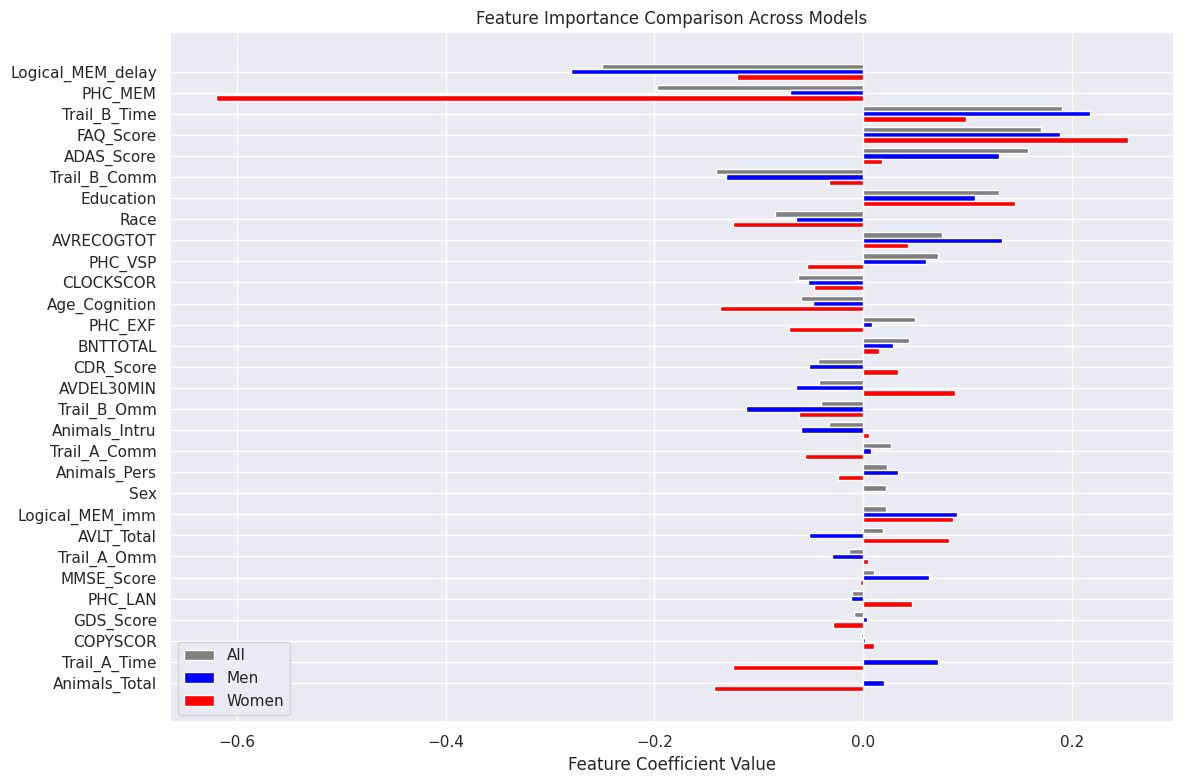

In [29]:
results_all = machine_learning(x,y)
results_men = machine_learning(x_men, y_men)
results_women = machine_learning(x_women, y_women)


import pandas as pd

df_fi = pd.DataFrame({
    'All': results_all['feature_importance'],
    'Men': results_men['feature_importance'],
    'Women': results_women['feature_importance'],
}).fillna(0)  # fill missing features with 0 importance


import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

# Sort features by importance in 'All' (or by mean importance)
features_sorted = df_fi['All'].abs().sort_values(ascending=False).index

df_fi = df_fi.loc[features_sorted]

bar_width = 0.25
indices = np.arange(len(df_fi))

plt.barh(indices - bar_width, df_fi['All'], height=bar_width, label='All', color='gray')
plt.barh(indices, df_fi['Men'], height=bar_width, label='Men', color='blue')
plt.barh(indices + bar_width, df_fi['Women'], height=bar_width, label='Women', color='red')

plt.yticks(indices, df_fi.index)
plt.xlabel('Feature Coefficient Value')
plt.title('Feature Importance Comparison Across Models')
plt.legend()
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()


Logical_MEM_delay   -0.250509
PHC_MEM             -0.197866
Trail_B_Time         0.190375
FAQ_Score            0.170548
ADAS_Score           0.157521
Trail_B_Comm        -0.140528
Education            0.130256
Race                -0.084562
AVRECOGTOT           0.075471
PHC_VSP              0.071610
CLOCKSCOR           -0.062376
Age_Cognition       -0.059781
PHC_EXF              0.049998
BNTTOTAL             0.044260
CDR_Score           -0.043525
AVDEL30MIN          -0.041855
Trail_B_Omm         -0.040491
Animals_Intru       -0.032963
Trail_A_Comm         0.026664
Animals_Pers         0.022866
Sex                  0.021889
Logical_MEM_imm      0.021798
AVLT_Total           0.018958
Trail_A_Omm         -0.013263
MMSE_Score           0.010428
PHC_LAN             -0.010368
GDS_Score           -0.009051
COPYSCOR            -0.001622
Trail_A_Time         0.000489
Animals_Total       -0.000178
dtype: float64
Logical_MEM_delay   -0.279480
Trail_B_Time         0.217306
FAQ_Score            0.18

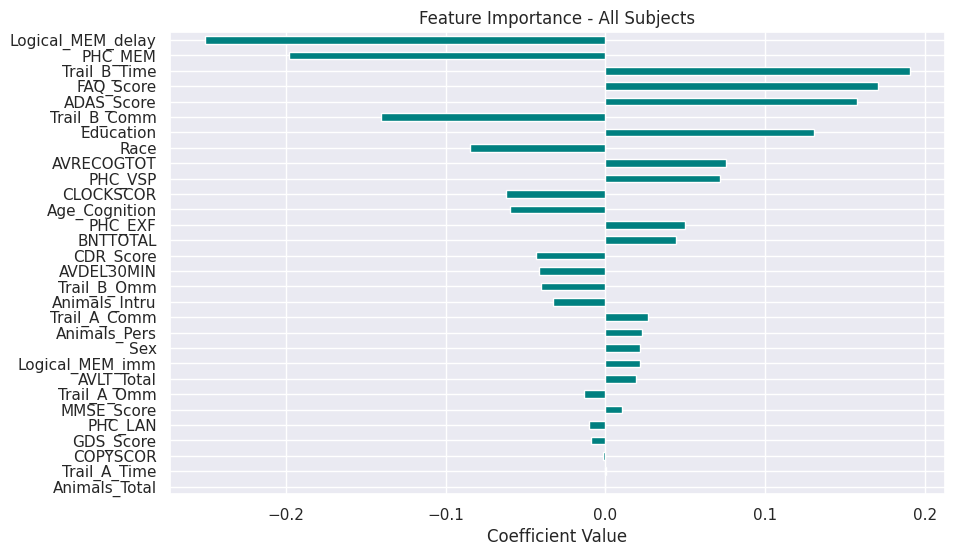

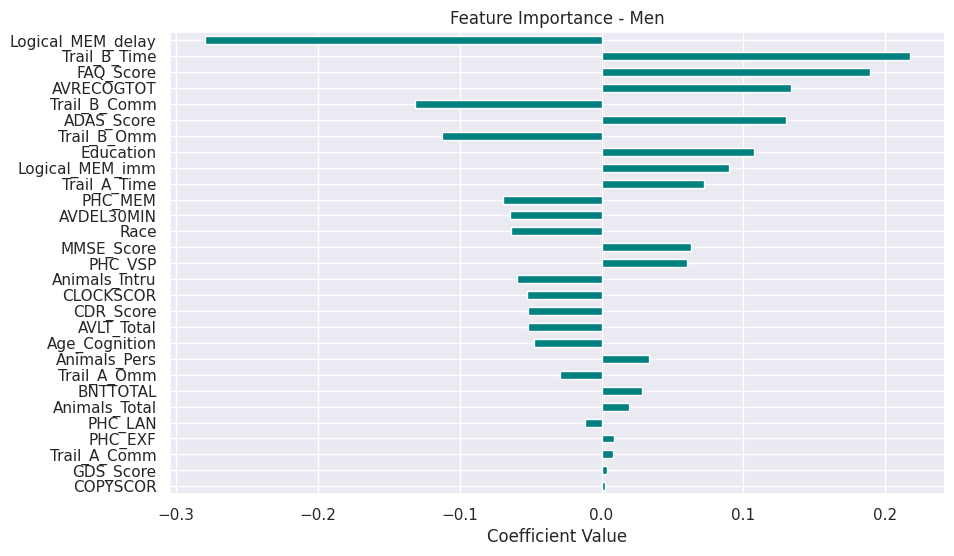

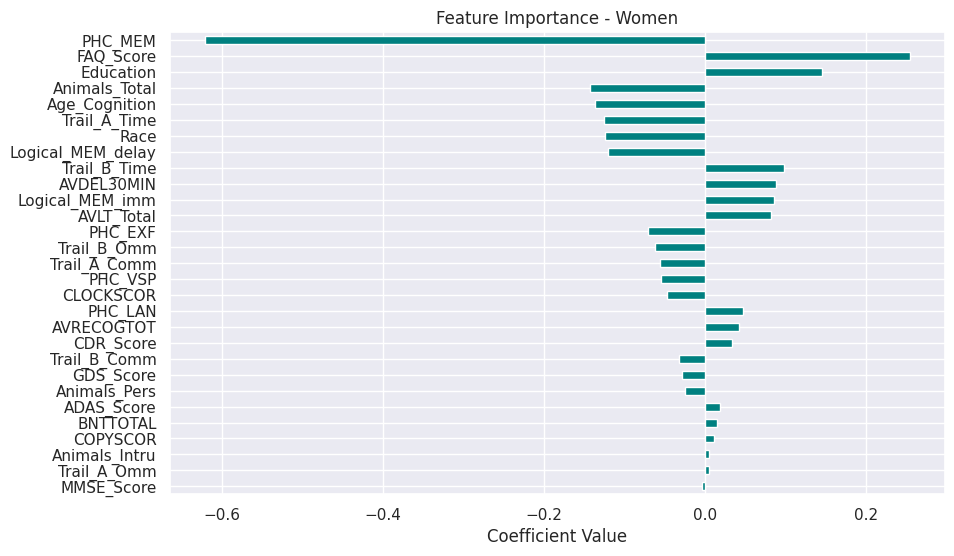

In [9]:
import matplotlib.pyplot as plt

results_all = machine_learning(x,y)
results_men = machine_learning(x_men, y_men)
results_women = machine_learning(x_women, y_women)



def plot_feature_importance(feature_importance, title):
    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='barh', color='teal')
    plt.xlabel('Coefficient Value')
    plt.title(title)
    plt.gca().invert_yaxis()  # highest importance on top
    plt.show()

plot_feature_importance(results_all['feature_importance'], 'Feature Importance - All Subjects')
plot_feature_importance(results_men['feature_importance'], 'Feature Importance - Men')
plot_feature_importance(results_women['feature_importance'], 'Feature Importance - Women')


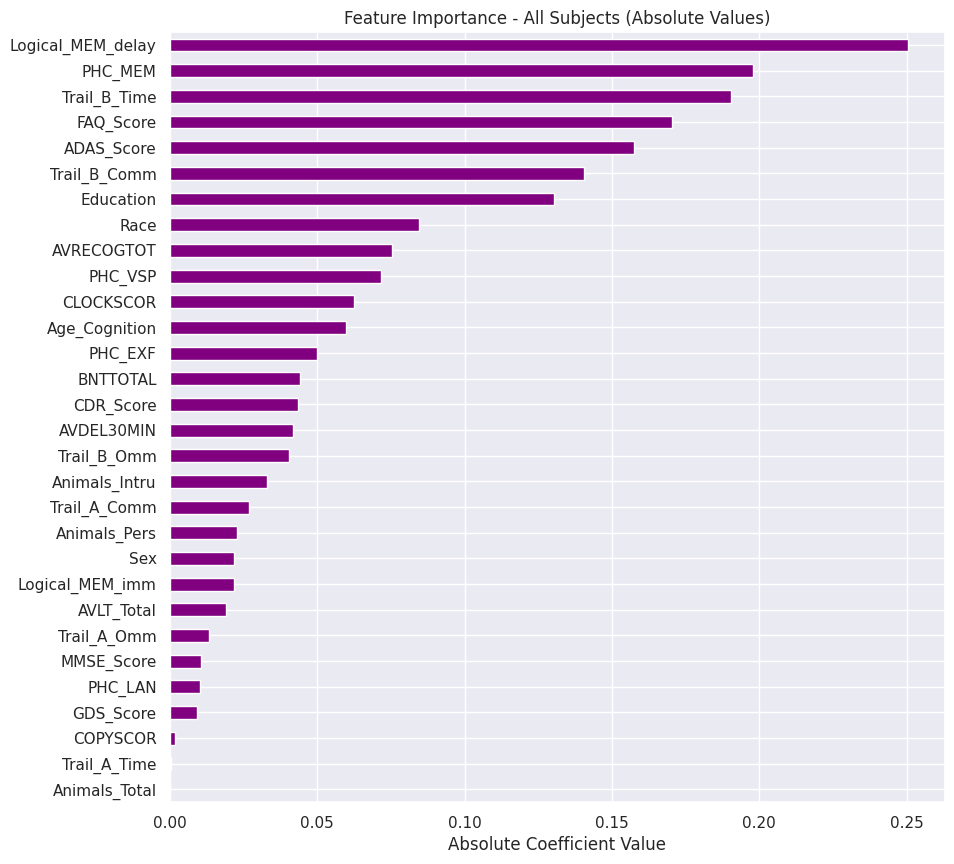

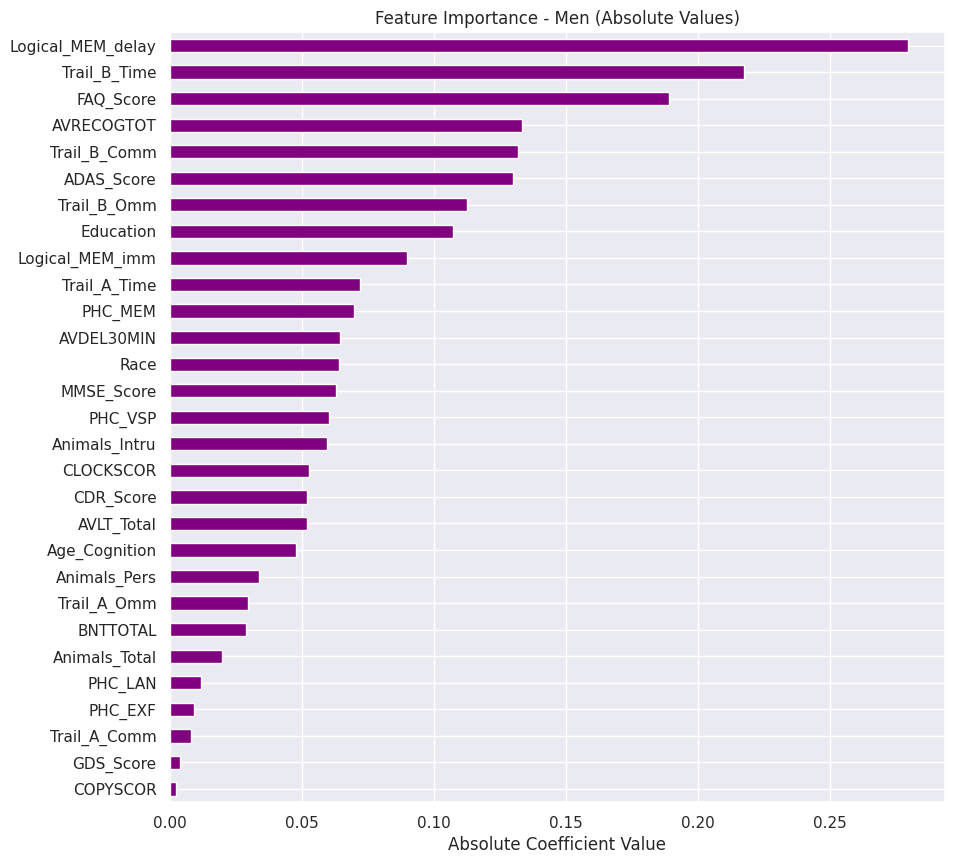

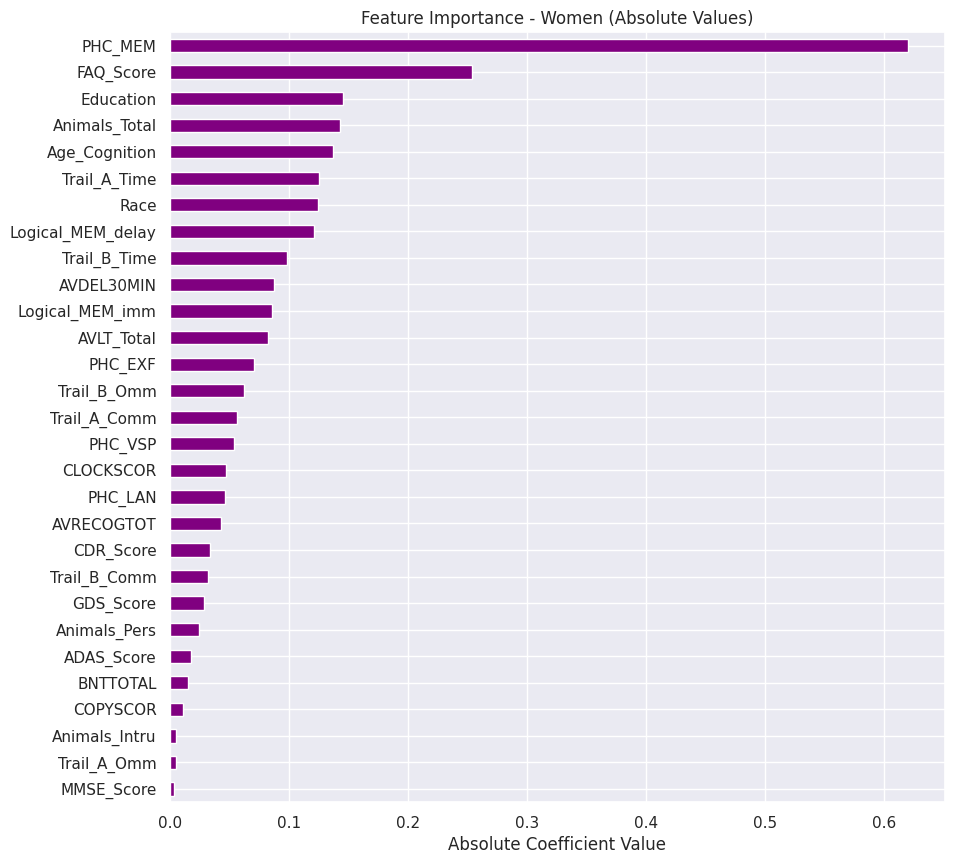

In [25]:
import matplotlib.pyplot as plt

def plot_feature_importance_abs(feature_importance, title):
    plt.figure(figsize=(10, 10))
    feature_importance_abs = feature_importance.abs()
    feature_importance_abs = feature_importance_abs.sort_values(ascending=True)
    feature_importance_abs.plot(kind='barh', color='purple')
    plt.xlabel('Absolute Coefficient Value')
    plt.title(title + ' (Absolute Values)')
    plt.show()

# Assuming you have results for each:
plot_feature_importance_abs(results_all['feature_importance'], 'Feature Importance - All Subjects')
plot_feature_importance_abs(results_men['feature_importance'], 'Feature Importance - Men')
plot_feature_importance_abs(results_women['feature_importance'], 'Feature Importance - Women')


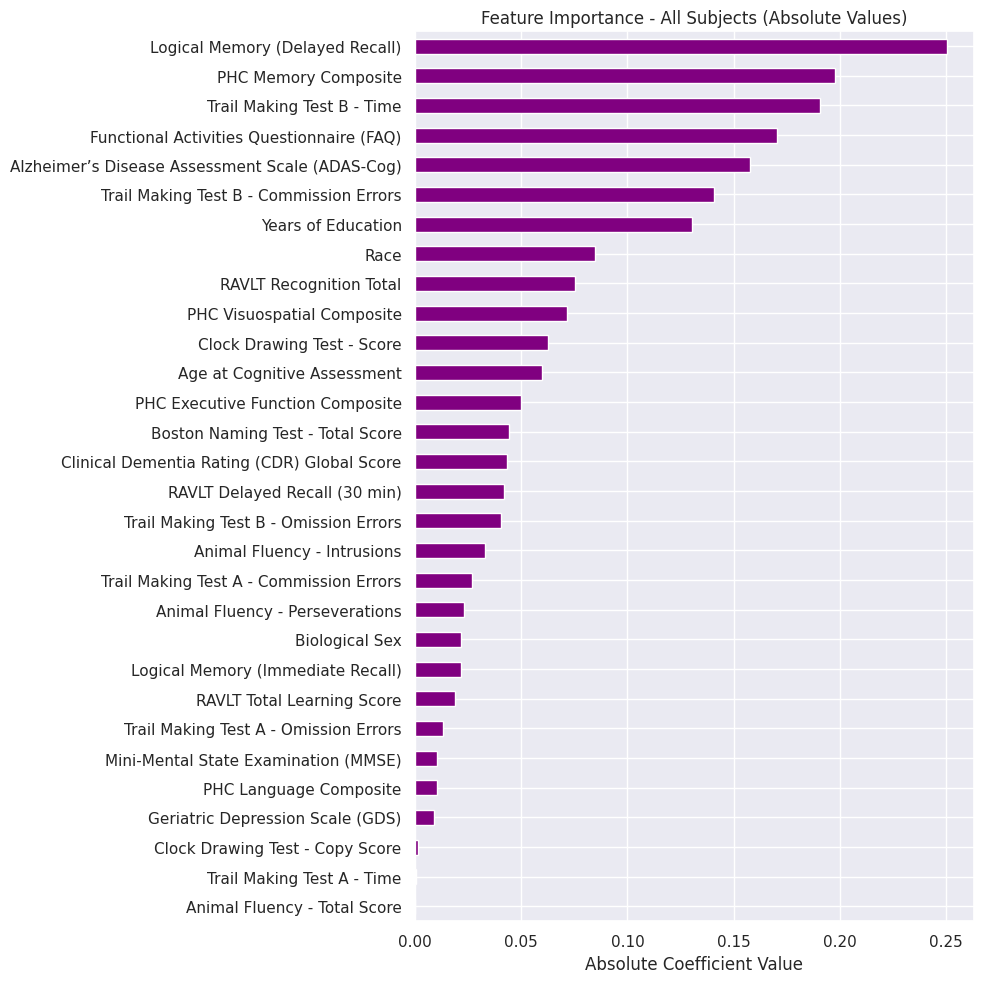

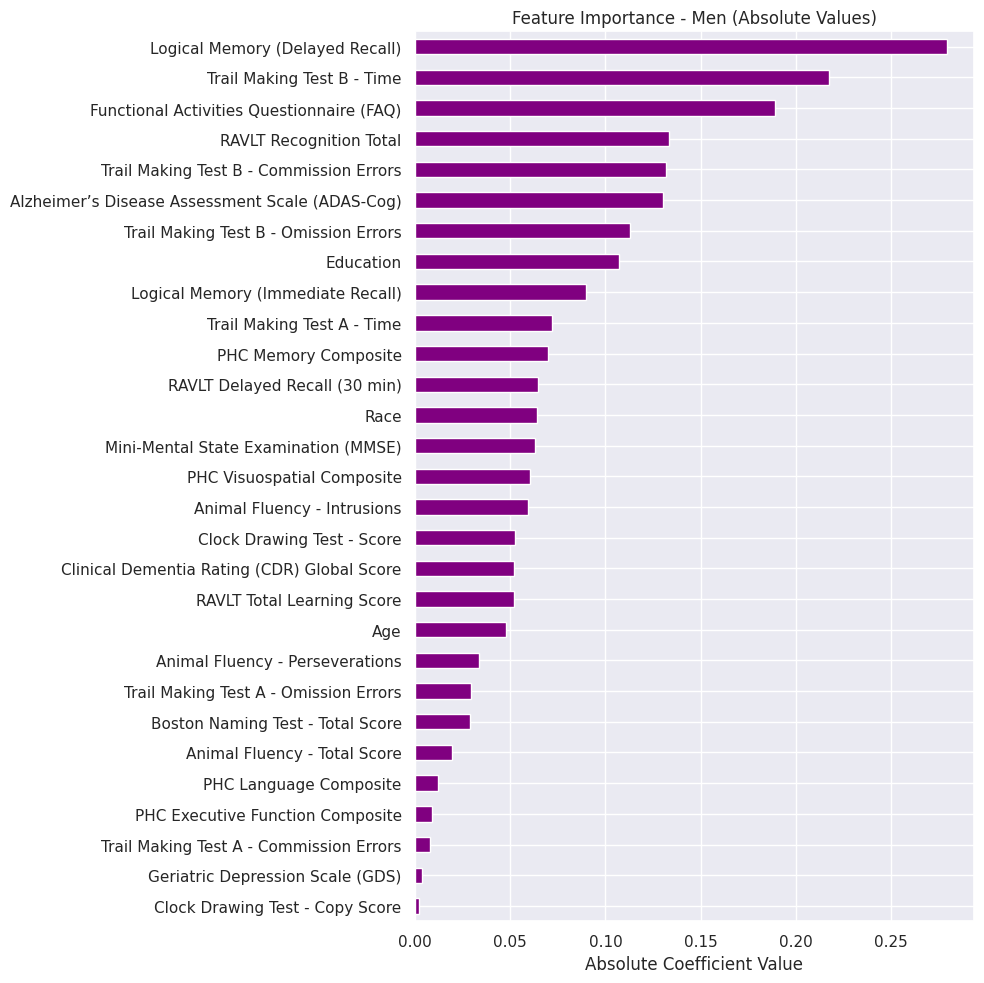

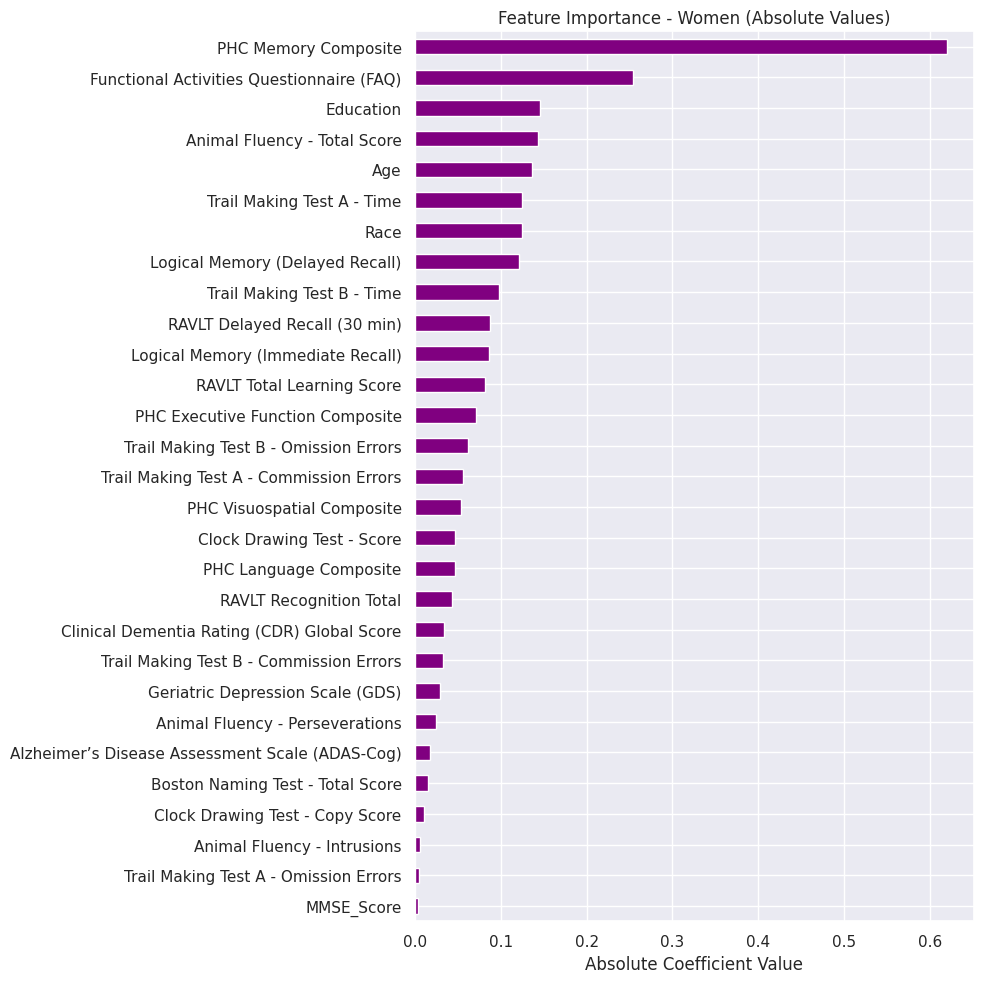

In [26]:
import matplotlib.pyplot as plt

def plot_feature_importance_abs(feature_importance, title, feature_name_mapping):
    plt.figure(figsize=(10, 10))
    feature_importance_abs = feature_importance.abs()
    # Rename features using the mapping (keep original if not found)
    feature_importance_abs = feature_importance_abs.rename(index=lambda x: feature_name_mapping.get(x, x))
    feature_importance_abs = feature_importance_abs.sort_values(ascending=True)
    feature_importance_abs.plot(kind='barh', color='purple')
    plt.xlabel('Absolute Coefficient Value')
    plt.title(title + ' (Absolute Values)')
    plt.tight_layout()
    plt.show()

# Call the function with each results and corresponding mapping

plot_feature_importance_abs(results_all['feature_importance'], 'Feature Importance - All Subjects', feature_name_mapping)
plot_feature_importance_abs(results_men['feature_importance'], 'Feature Importance - Men', feature_name_mapping_men)
plot_feature_importance_abs(results_women['feature_importance'], 'Feature Importance - Women', feature_name_mapping_women)


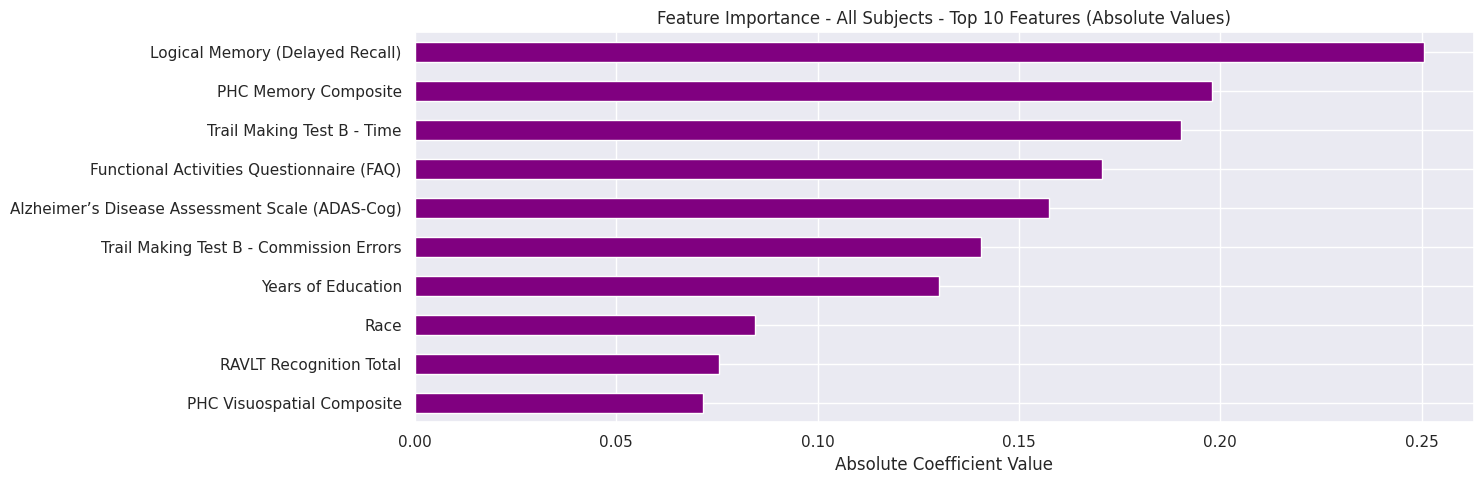

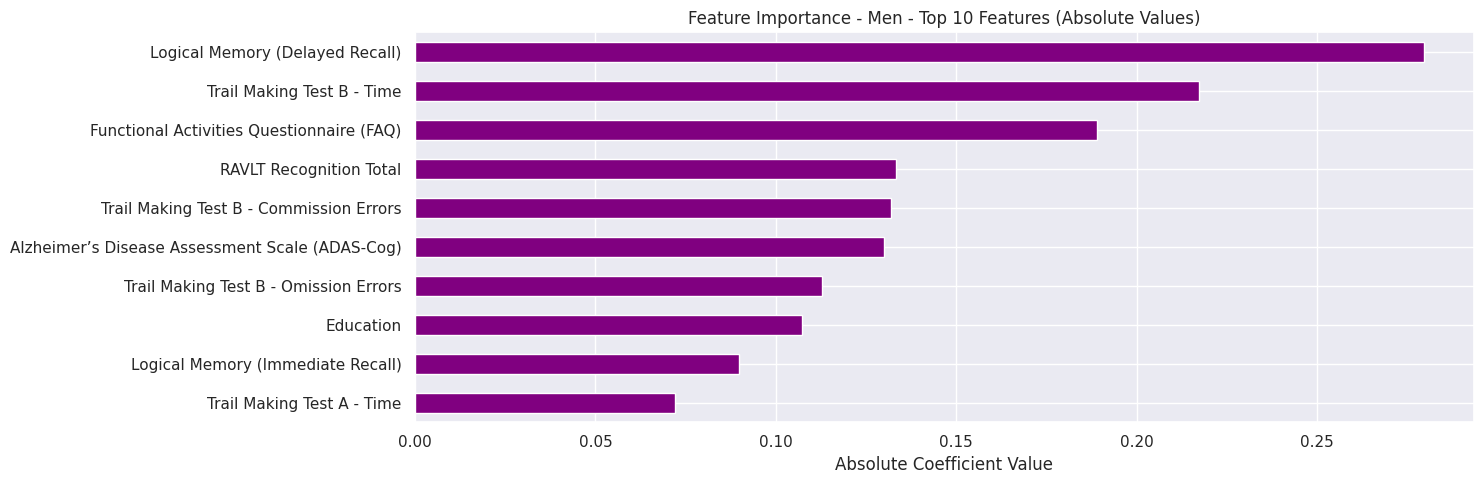

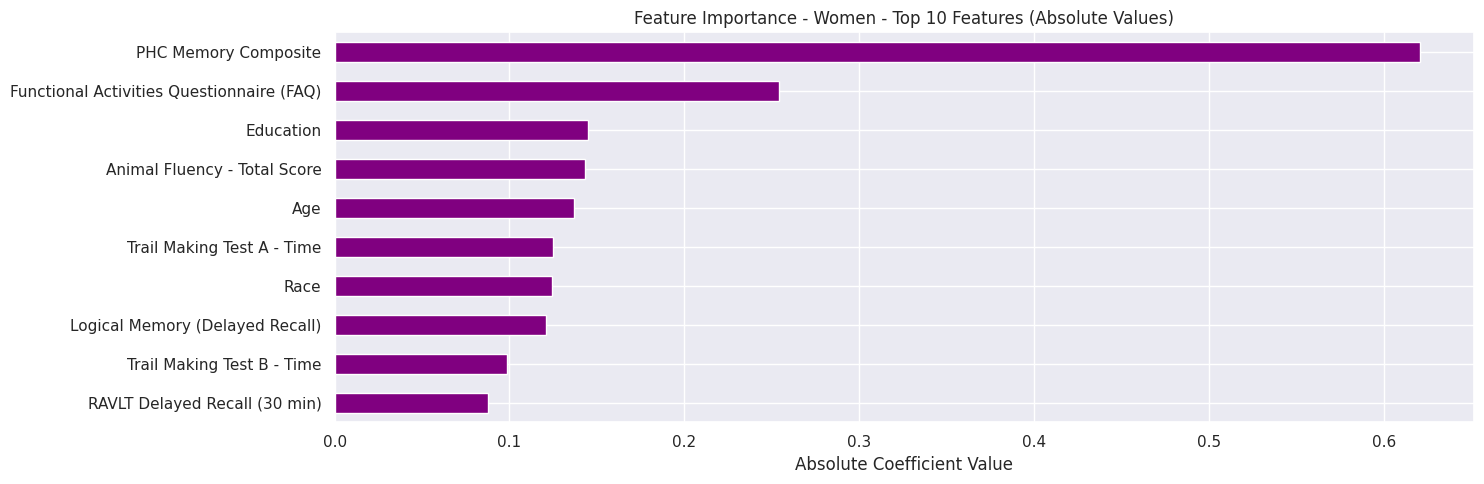

In [31]:
import matplotlib.pyplot as plt

def plot_top10_feature_importance_abs(feature_importance, title, feature_name_mapping):
    plt.figure(figsize=(15, 5))
    feature_importance_abs = feature_importance.abs()
    top10_features = feature_importance_abs.sort_values(ascending=False).head(10)
    # Rename top 10 features using the mapping (keep original if not found)
    top10_features = top10_features.rename(index=lambda x: feature_name_mapping.get(x, x))
    top10_features = top10_features.sort_values()  # sort for prettier horizontal bar plot
    top10_features.plot(kind='barh', color='purple')
    plt.xlabel('Absolute Coefficient Value')
    plt.title(title + ' - Top 10 Features (Absolute Values)')
    plt.tight_layout()
    plt.show()

# Call the function with each results and corresponding mapping

plot_top10_feature_importance_abs(results_all['feature_importance'], 'Feature Importance - All Subjects', feature_name_mapping)
plot_top10_feature_importance_abs(results_men['feature_importance'], 'Feature Importance - Men', feature_name_mapping_men)
plot_top10_feature_importance_abs(results_women['feature_importance'], 'Feature Importance - Women', feature_name_mapping_women)


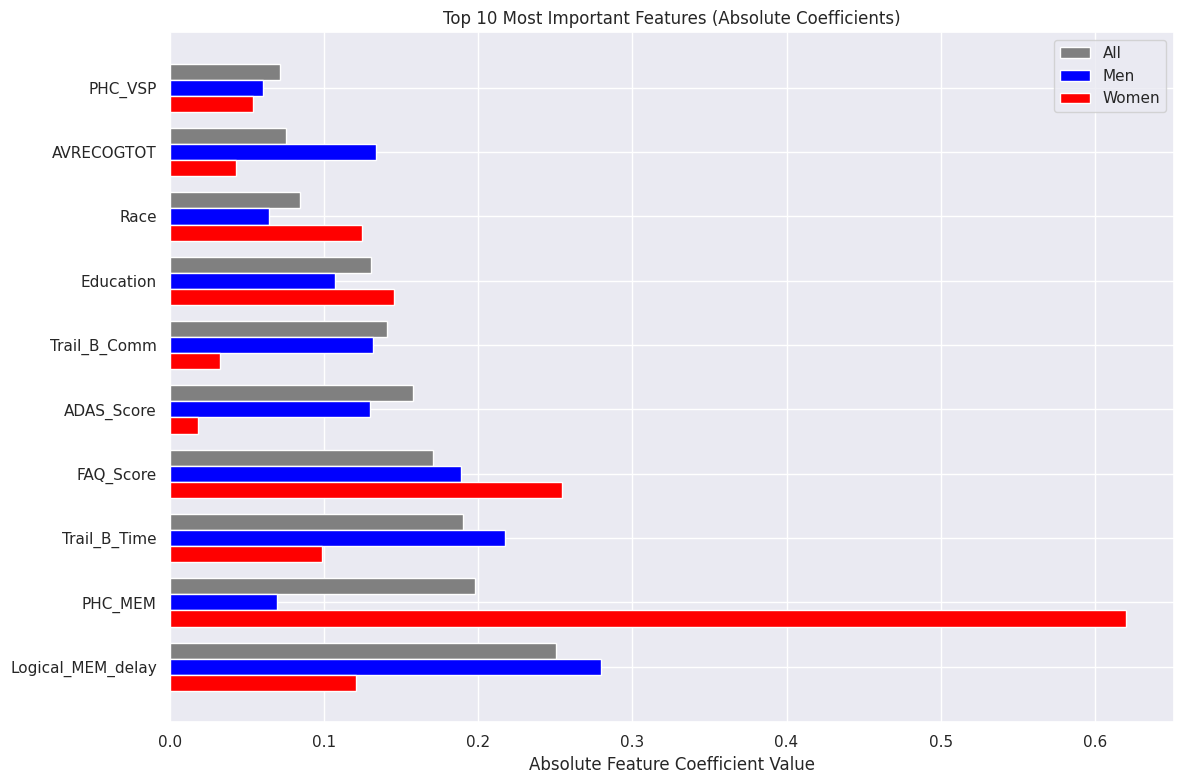

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Combine feature importances into a DataFrame
df_fi = pd.DataFrame({
    'All': results_all['feature_importance'],
    'Men': results_men['feature_importance'],
    'Women': results_women['feature_importance'],
}).fillna(0)

# Take absolute values
df_fi = df_fi.abs()

# Select top 10 features based on 'All'
top10_features = df_fi['All'].sort_values(ascending=False).head(10).index
df_fi_top10 = df_fi.loc[top10_features]

# Sort for prettier horizontal bar plot
df_fi_top10 = df_fi_top10.sort_values(by='All')

# Plotting
plt.figure(figsize=(12, 8))

bar_width = 0.25
indices = np.arange(len(df_fi_top10))

plt.barh(indices - bar_width, df_fi_top10['All'], height=bar_width, label='All', color='gray')
plt.barh(indices, df_fi_top10['Men'], height=bar_width, label='Men', color='blue')
plt.barh(indices + bar_width, df_fi_top10['Women'], height=bar_width, label='Women', color='red')

plt.yticks(indices, df_fi_top10.index)
plt.xlabel('Absolute Feature Coefficient Value')
plt.title('Top 10 Most Important Features (Absolute Coefficients)')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


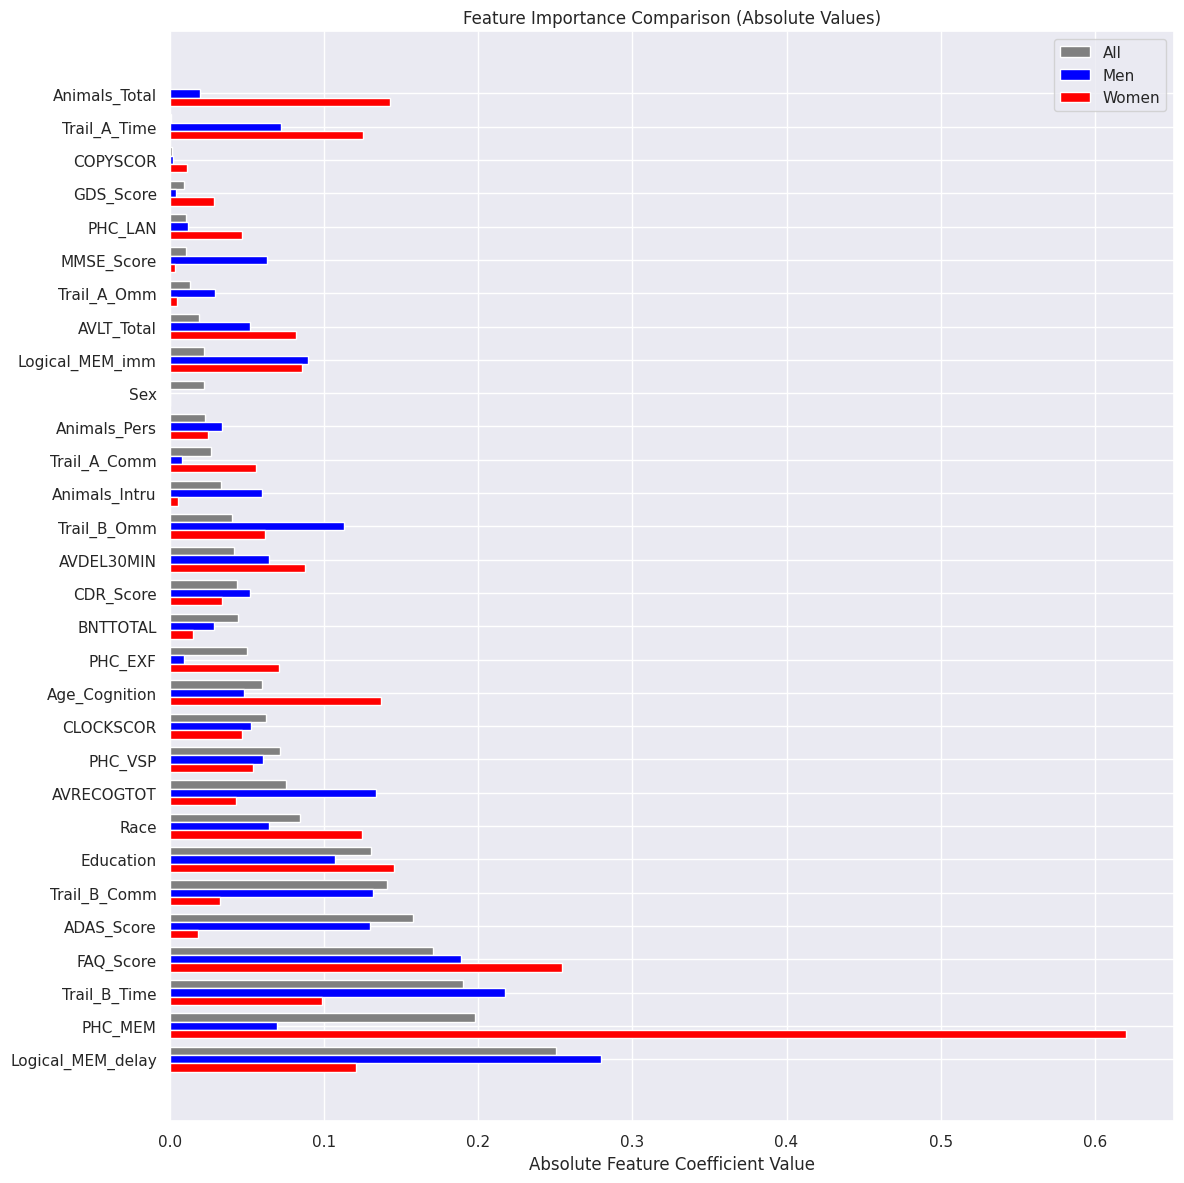

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Combine feature importances into a DataFrame
df_fi = pd.DataFrame({
    'All': results_all['feature_importance'],
    'Men': results_men['feature_importance'],
    'Women': results_women['feature_importance'],
}).fillna(0)

# Take absolute values
df_fi = df_fi.abs()

# Sort features by 'All' importance
df_fi = df_fi.sort_values(by='All')

# Plotting
plt.figure(figsize=(12, max(6, 0.4 * len(df_fi))))  # adjust height for many features

bar_width = 0.25
indices = np.arange(len(df_fi))

plt.barh(indices - bar_width, df_fi['All'], height=bar_width, label='All', color='gray')
plt.barh(indices, df_fi['Men'], height=bar_width, label='Men', color='blue')
plt.barh(indices + bar_width, df_fi['Women'], height=bar_width, label='Women', color='red')

plt.yticks(indices, df_fi.index)
plt.xlabel('Absolute Feature Coefficient Value')
plt.title('Feature Importance Comparison (Absolute Values)')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
